# Comparing different rejection options PBMC

Here, we create cell-type hierarchies for the PBMC datasets using different parameters for the three rejection options. The latent space can be downloaded from [zenodo](https://doi.org/10.5281/zenodo.6786357)

This notebook reproduces Figure S4

In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import copy as cp
import seaborn as sns
import pandas as pd

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=1000, frameon=False)
sc.set_figure_params(dpi=1000)
sc.set_figure_params(figsize=(7,7))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

In [4]:
### Load the reference + query latent space

reference_latent = sc.read('ref_model/ref_latent.h5ad')
reference_latent

AnnData object with n_obs × n_vars = 21757 × 10
    obs: 'cell_type', 'batch', 'study', 'leiden'
    uns: 'cell_type_colors', 'leiden', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [5]:
reference_latent.obs['cell_type2'] = 0
reference_latent.obs['cell_type2'] = cp.deepcopy(reference_latent.obs['cell_type'].astype('str'))

idx_lymphoid = ((reference_latent.obs['study'] == 'Sun') & 
                np.isin(reference_latent.obs['cell_type'], 
                        ['CD20+ B cells', 
                         'CD4+ T cells', 'CD8+ T cells', 
                         'NK cells', 'NKT cells']))
reference_latent.obs['cell_type2'].iloc[idx_lymphoid] = 'Group 1'

idx_myeloid = ((reference_latent.obs['study'] == 'Sun') & 
                np.isin(reference_latent.obs['cell_type'], 
                        ['CD14+ Monocytes', 'CD16+ Monocytes', 
                         'Monocyte-derived dendritic cells', 
                         'Plasmacytoid dendritic cells']))
reference_latent.obs['cell_type2'].iloc[idx_myeloid] = 'Group 2'

idx_T = ((reference_latent.obs['study'] == 'Oetjen') & 
                np.isin(reference_latent.obs['cell_type'], 
                        ['CD4+ T cells', 'CD8+ T cells']))
reference_latent.obs['cell_type2'].iloc[idx_T] = 'T cells'

idx_MC = ((reference_latent.obs['study'] == 'Oetjen') & 
                np.isin(reference_latent.obs['cell_type'], 
                        ['CD14+ Monocytes', 'CD16+ Monocytes']))
reference_latent.obs['cell_type2'].iloc[idx_MC] = 'Monocytes' 

reference_latent.obs['celltype_batch'] = np.char.add(np.char.add(np.array(reference_latent.obs['cell_type2'], dtype= str), '-'),
                                             np.array(reference_latent.obs['study'], dtype=str))

/tmp/ipykernel_3814696/1252372026.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference_latent.obs['cell_type2'].iloc[idx_lymphoid] = 'Group 1'
/tmp/ipykernel_3814696/1252372026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference_latent.obs['cell_type2'].iloc[idx_myeloid] = 'Group 2'
/tmp/ipykernel_3814696/1252372026.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference_latent.obs['cell_type2'].iloc[idx_T] =

In [6]:
query_latent = sc.read('surgery_model/query_latent.h5ad')
query_latent

AnnData object with n_obs × n_vars = 10727 × 10
    obs: 'cell_type', 'batch'

In [7]:
query_latent.obs['study'] = "10X"
query_latent.obs['cell_type2'] = query_latent.obs['cell_type']
full_latent  = reference_latent.concatenate(query_latent, batch_key="ref_query")


In [8]:
# Again make the labels unique
full_latent.obs['celltype_batch'] = np.char.add(np.char.add(np.array(full_latent.obs['cell_type2'], dtype= str), '-'),
                                             np.array(full_latent.obs['study'], dtype=str))

1
Rejection threshold: 0.25
Starting tree:


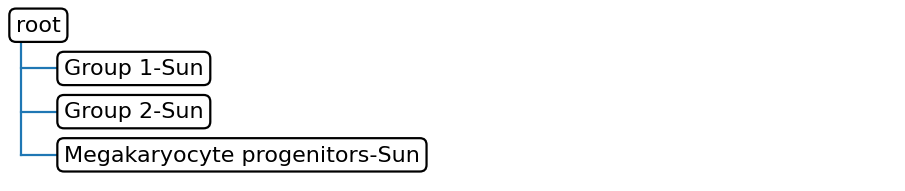


Adding dataset Oetjen to the tree

Updated tree:


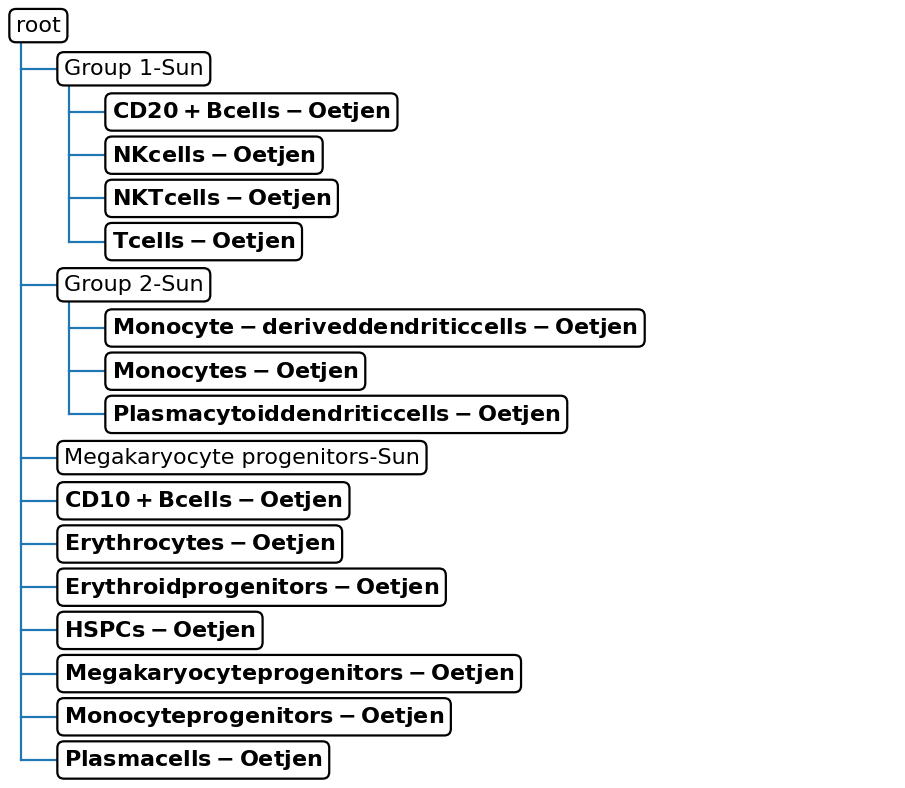


Adding dataset Freytag to the tree

Updated tree:


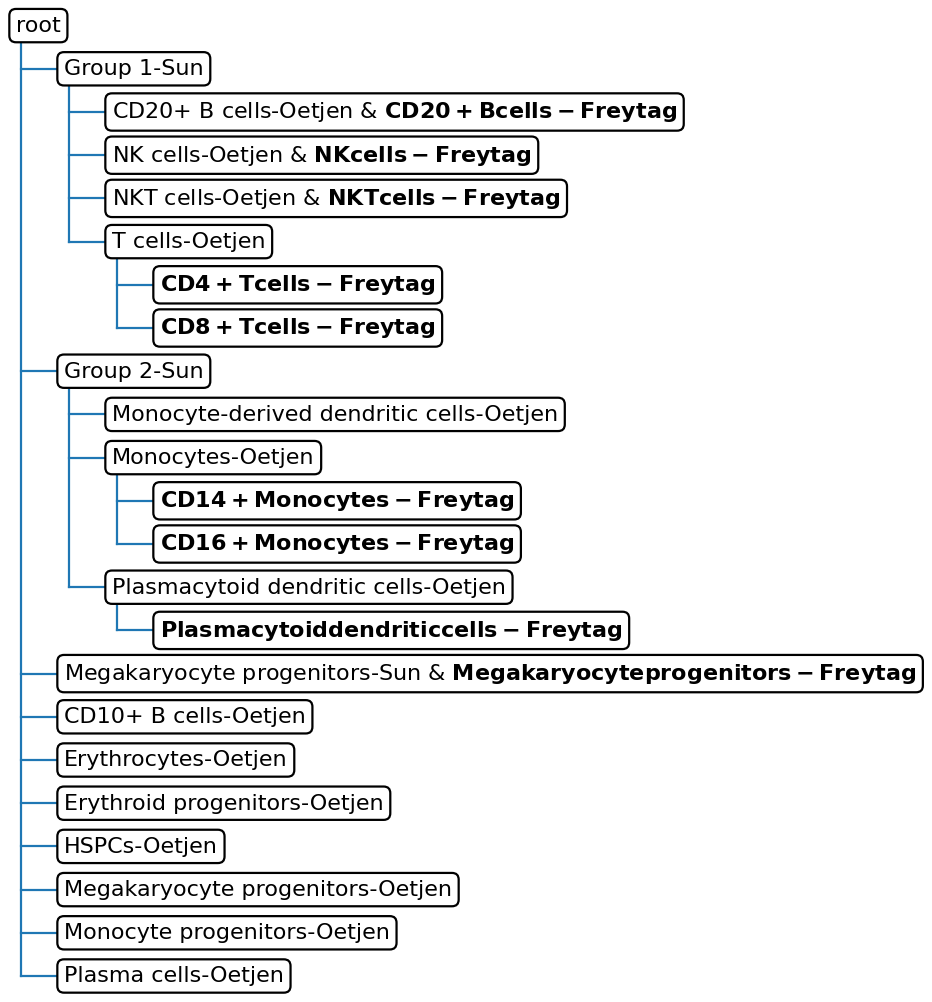


Adding dataset 10X to the tree

Updated tree:


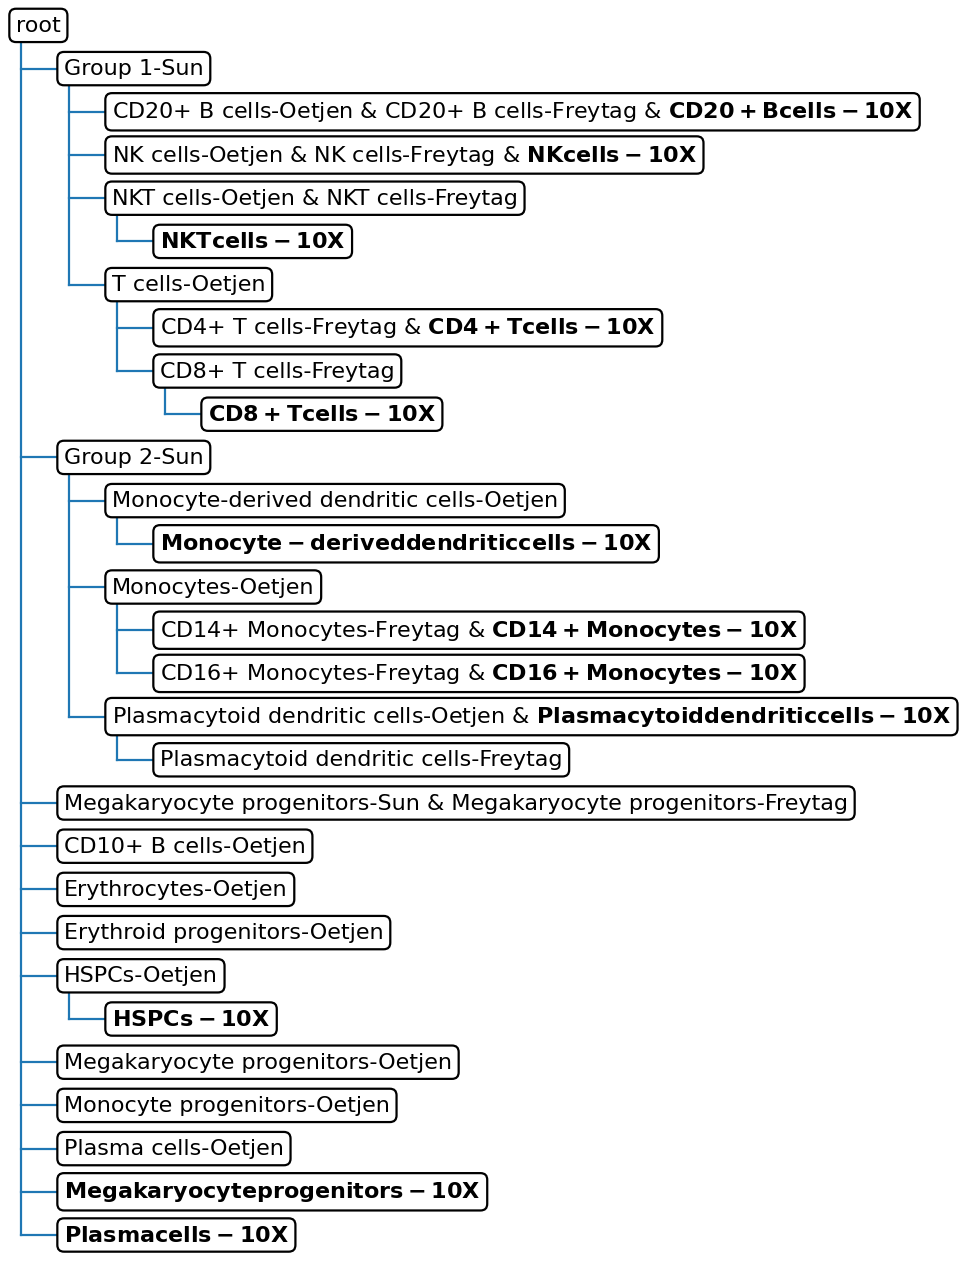

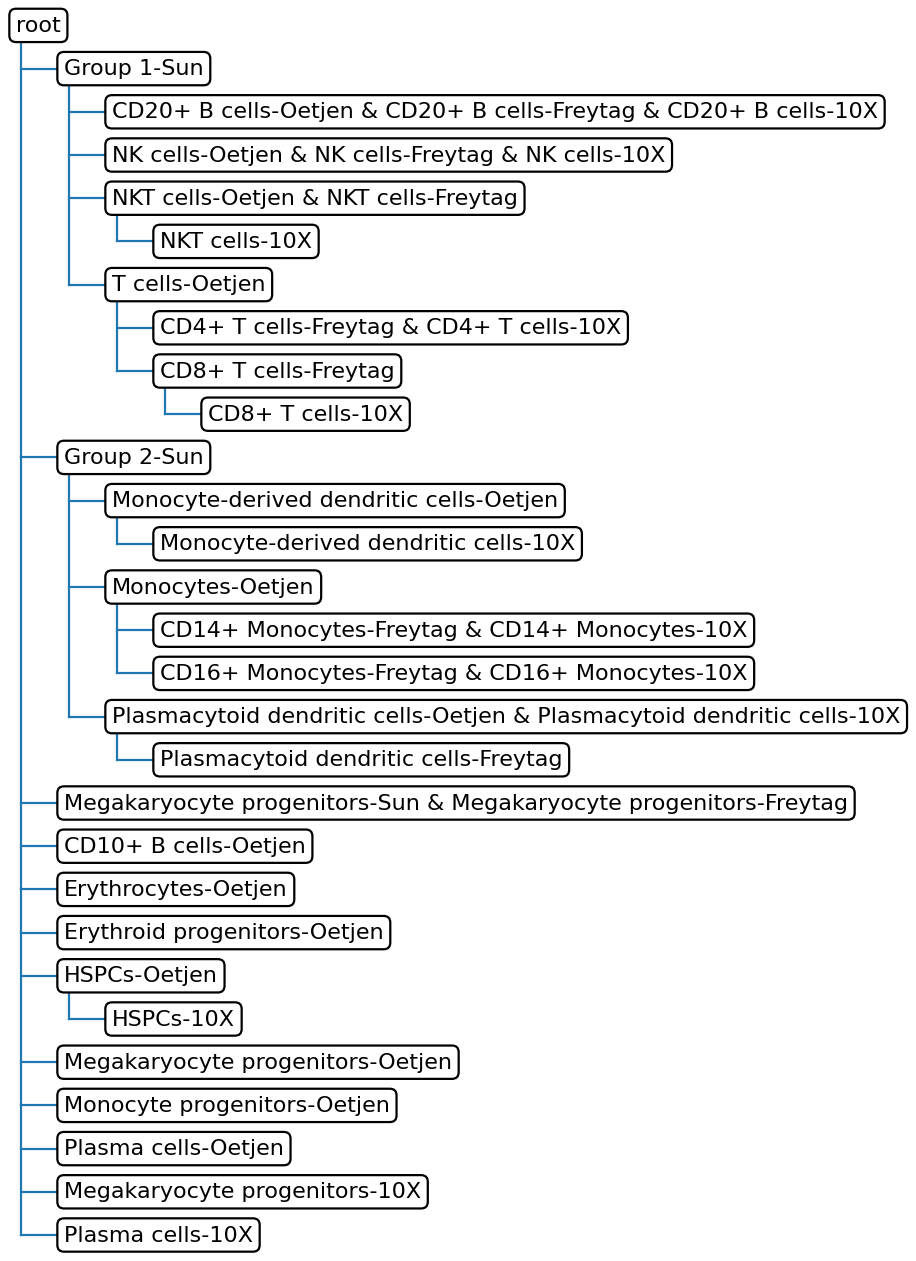

2
Rejection threshold: 0.5
Starting tree:


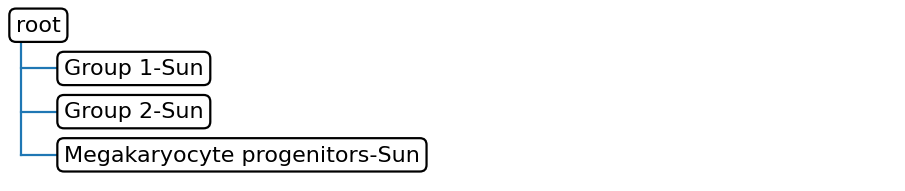


Adding dataset Oetjen to the tree

Updated tree:


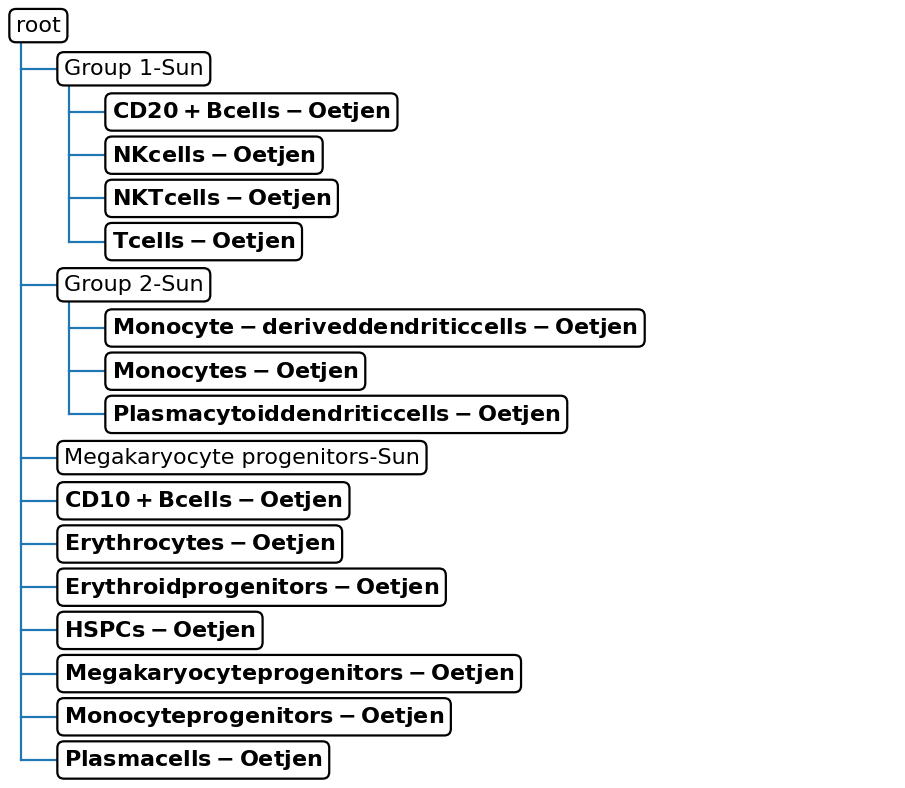


Adding dataset Freytag to the tree

Updated tree:


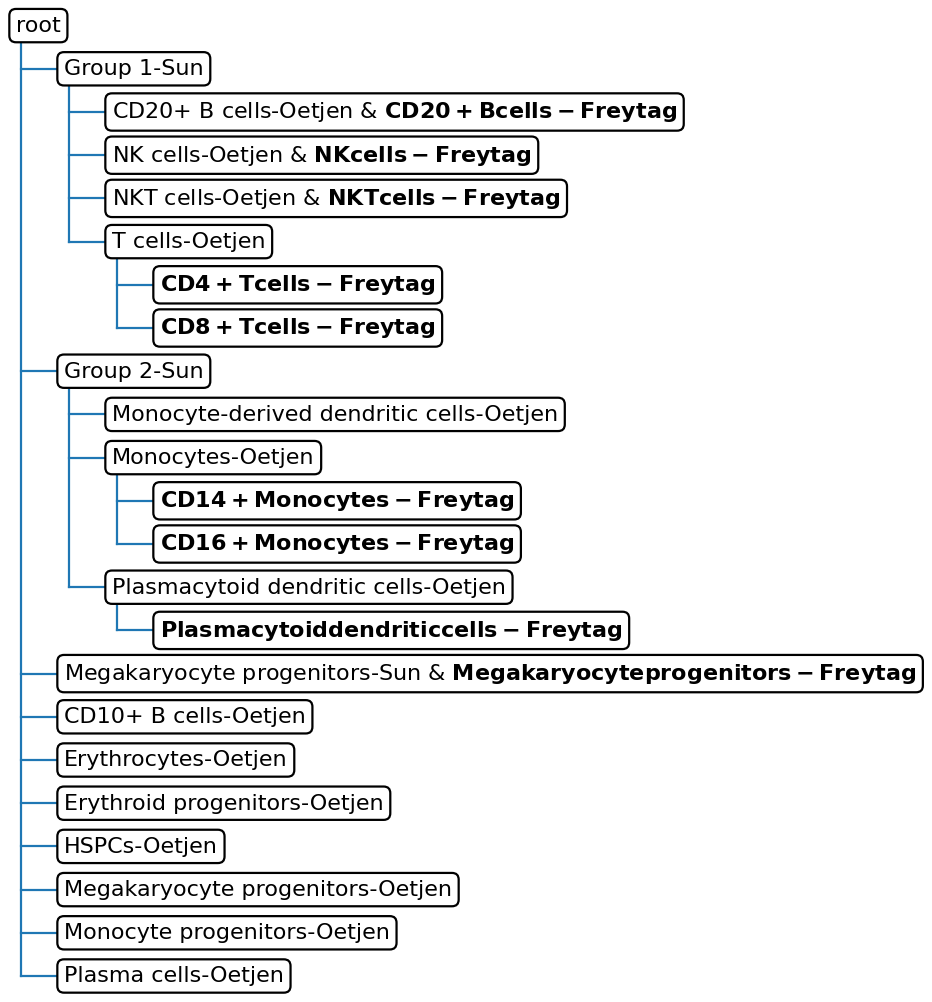


Adding dataset 10X to the tree

Updated tree:


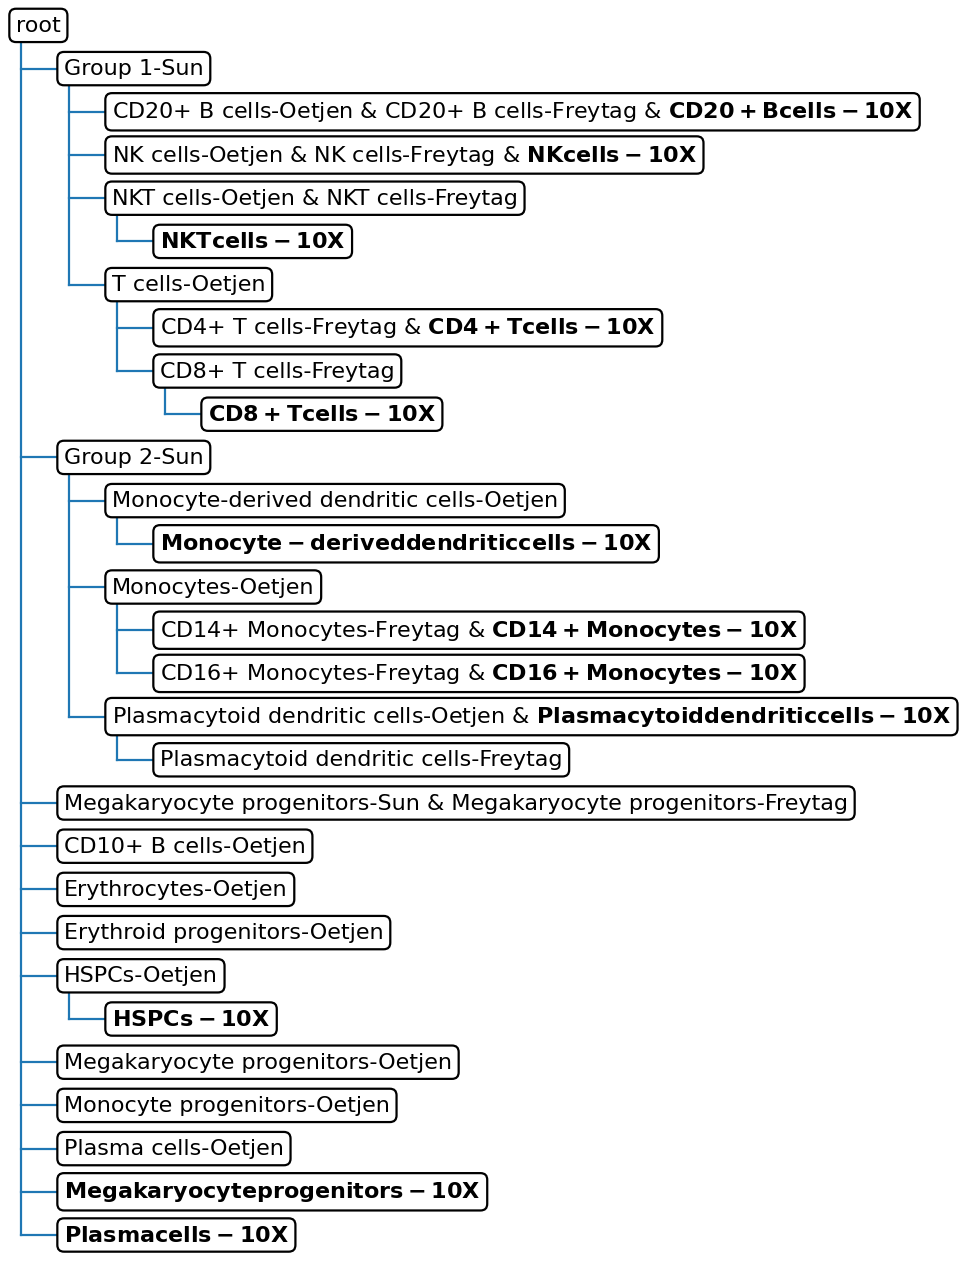

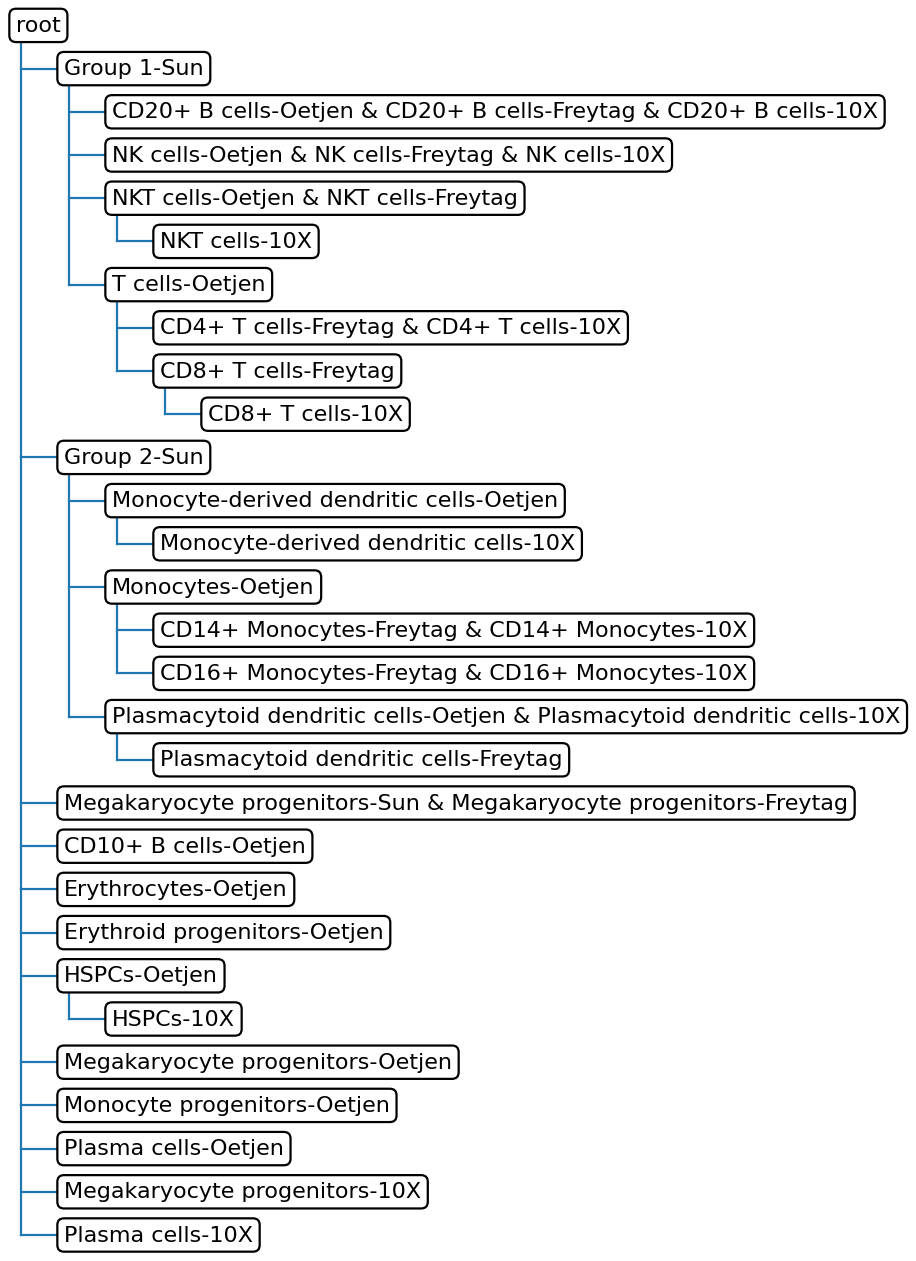

3
Rejection threshold: 0.75
Starting tree:


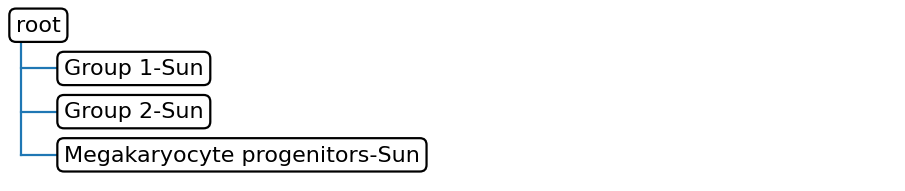


Adding dataset Oetjen to the tree

Updated tree:


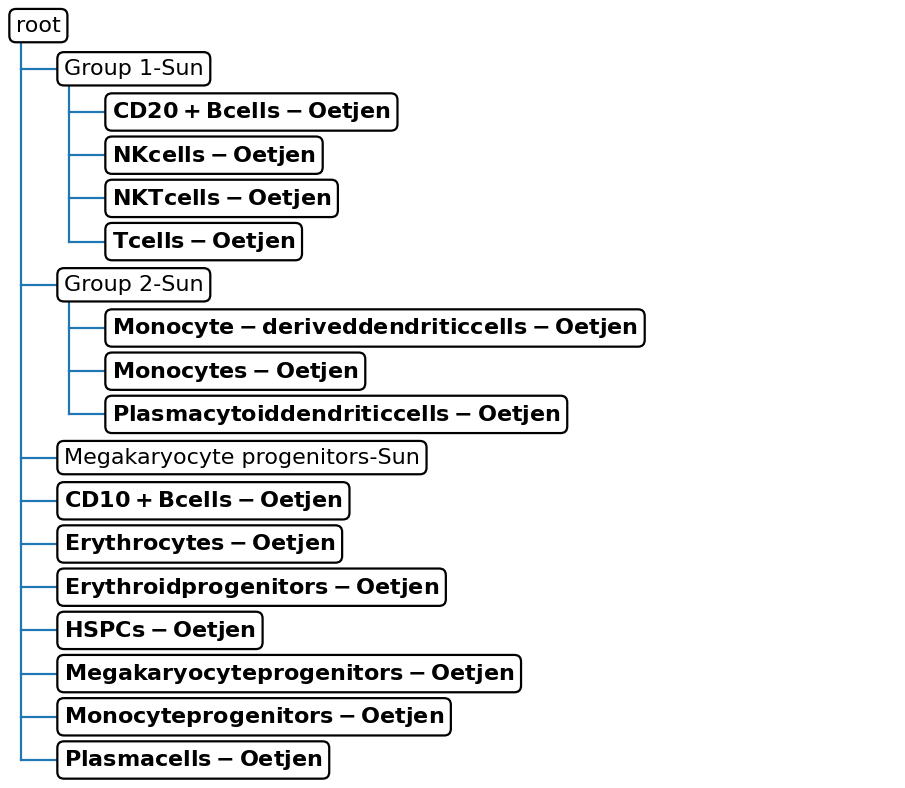


Adding dataset Freytag to the tree

Updated tree:


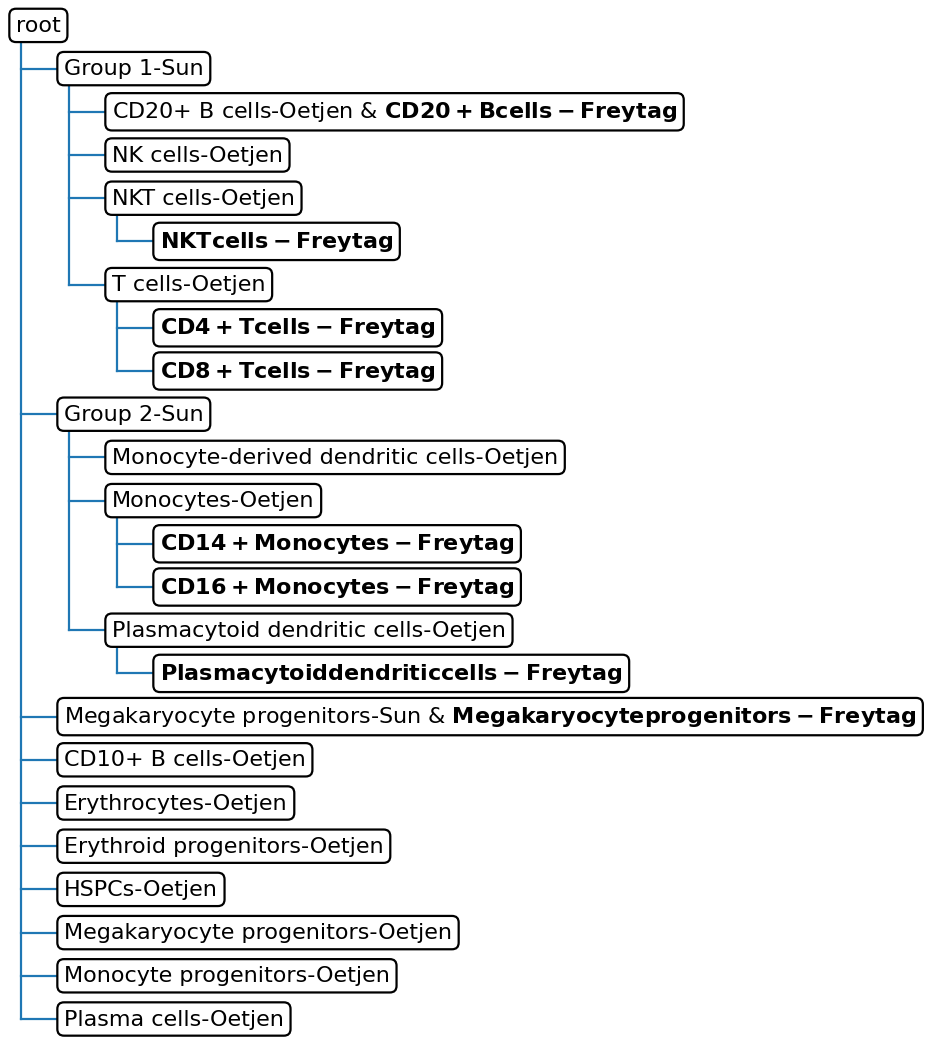


Adding dataset 10X to the tree
These populations are missing from the tree: 
['NKT cells-10X']

Updated tree:


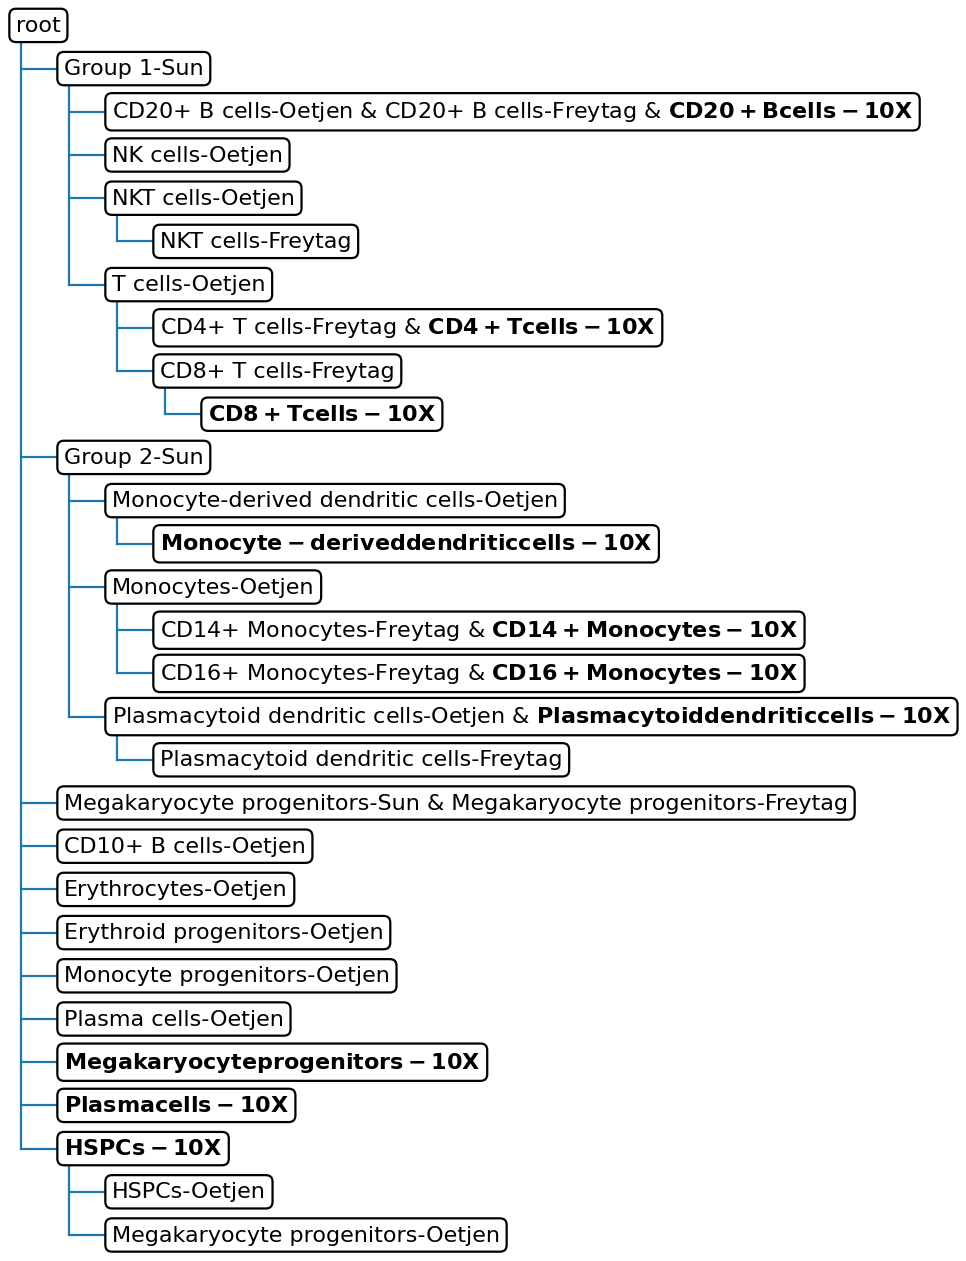

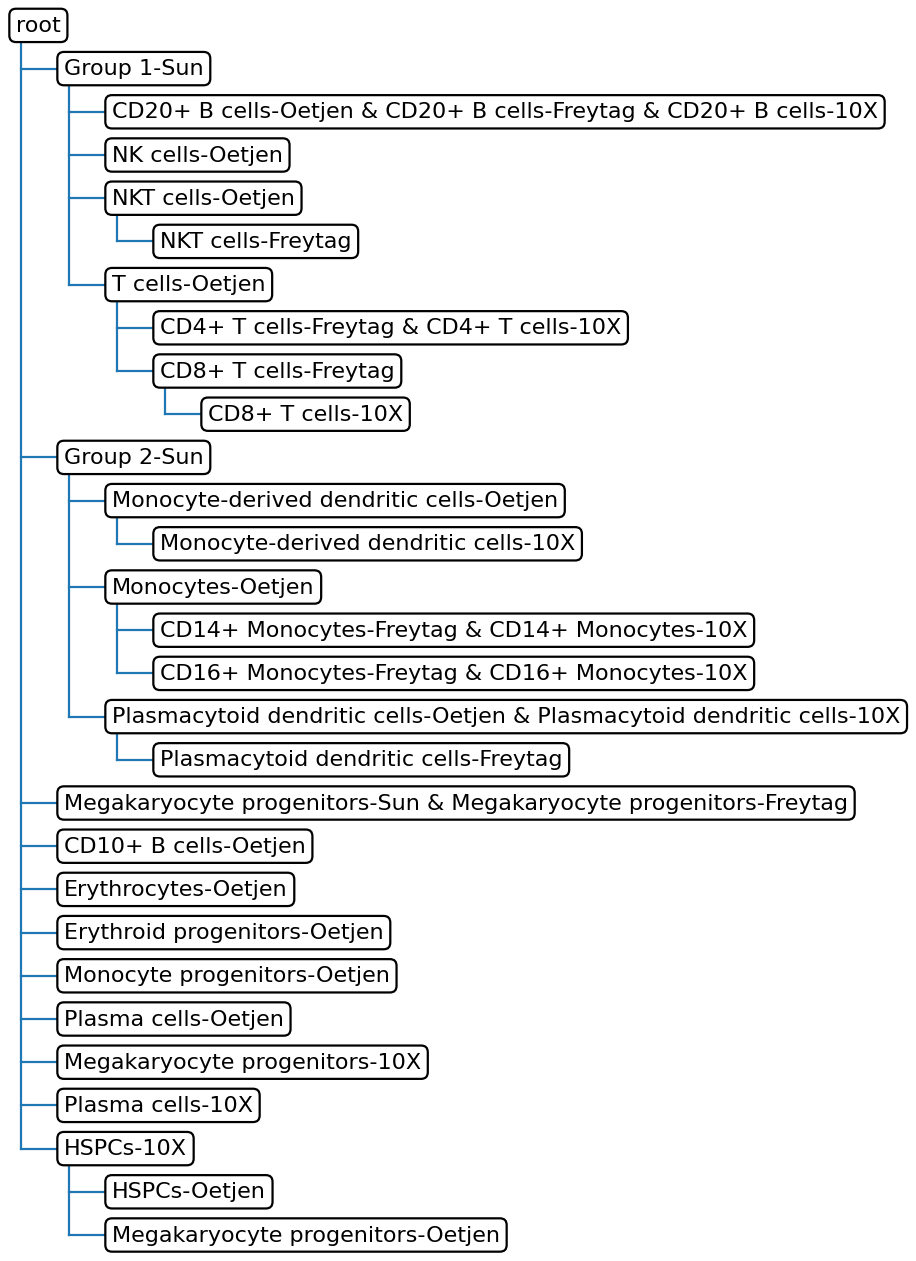

In [9]:
rej_threshold = [0.25, 0.5, 0.75] # Posterior probability
i = 1

for r in rej_threshold:
    print(i)
    print('Rejection threshold: ' + str(r))

    tree, mp = sca.classifiers.scHPL.learn_tree(data = full_latent, 
                    batch_key = 'study',
                    batch_order = ['Sun', 'Oetjen', 'Freytag', '10X'],
                    cell_type_key='celltype_batch',
                    classifier = 'knn', dynamic_neighbors=True,
                    dimred = False, print_conf= False,
                    rej_threshold = r)
    sca.classifiers.scHPL.utils.print_tree(tree)
    i += 1


1
Use reconstruction error?:True
FN: 0.25
Starting tree:


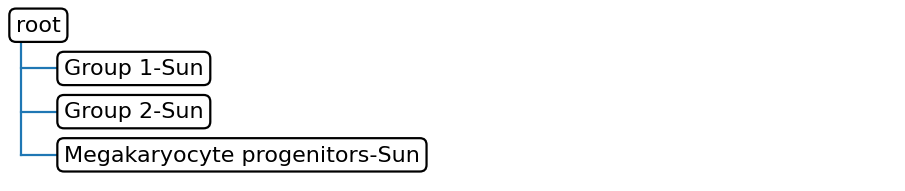


Adding dataset Oetjen to the tree

Updated tree:


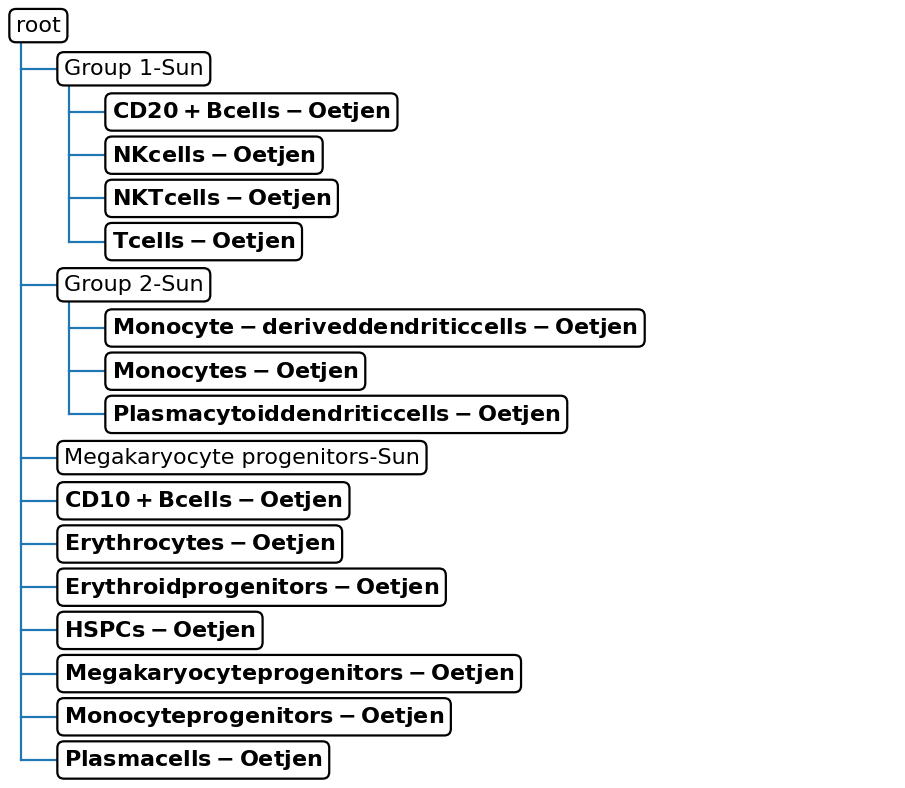


Adding dataset Freytag to the tree

Updated tree:


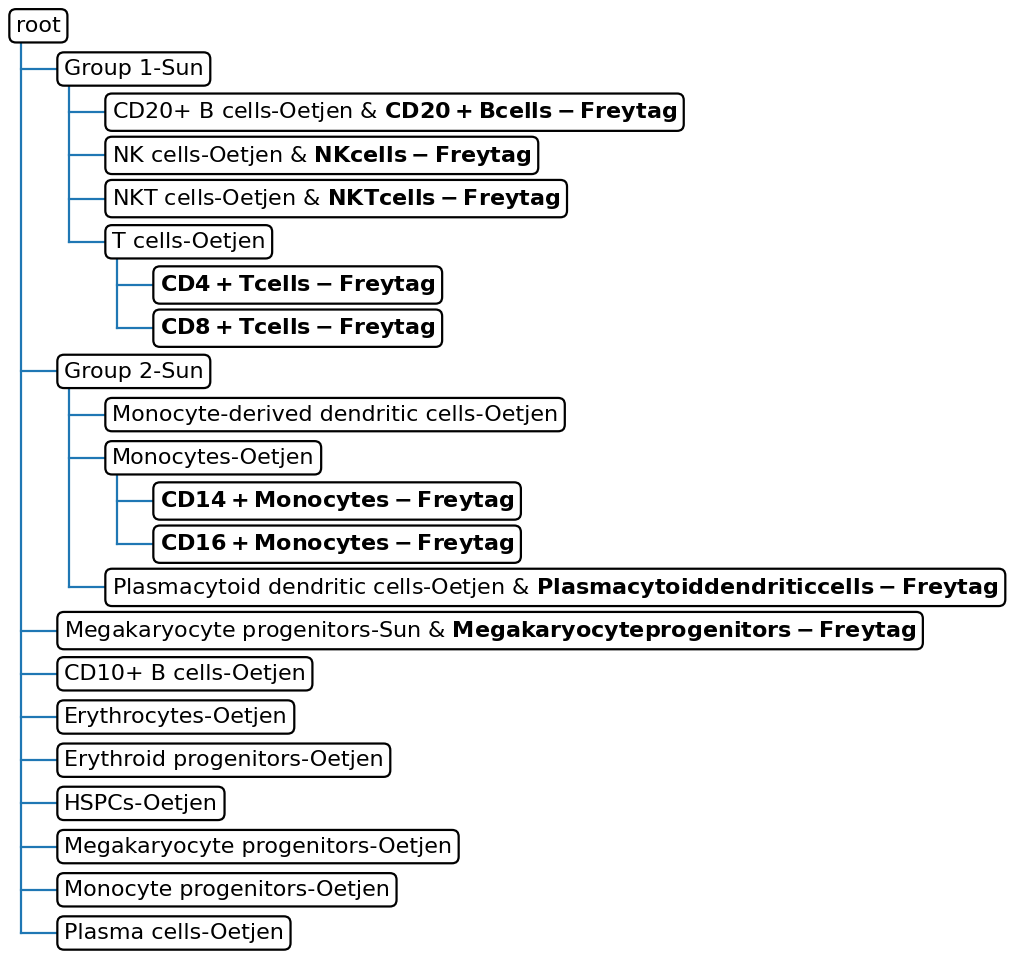


Adding dataset 10X to the tree

Updated tree:


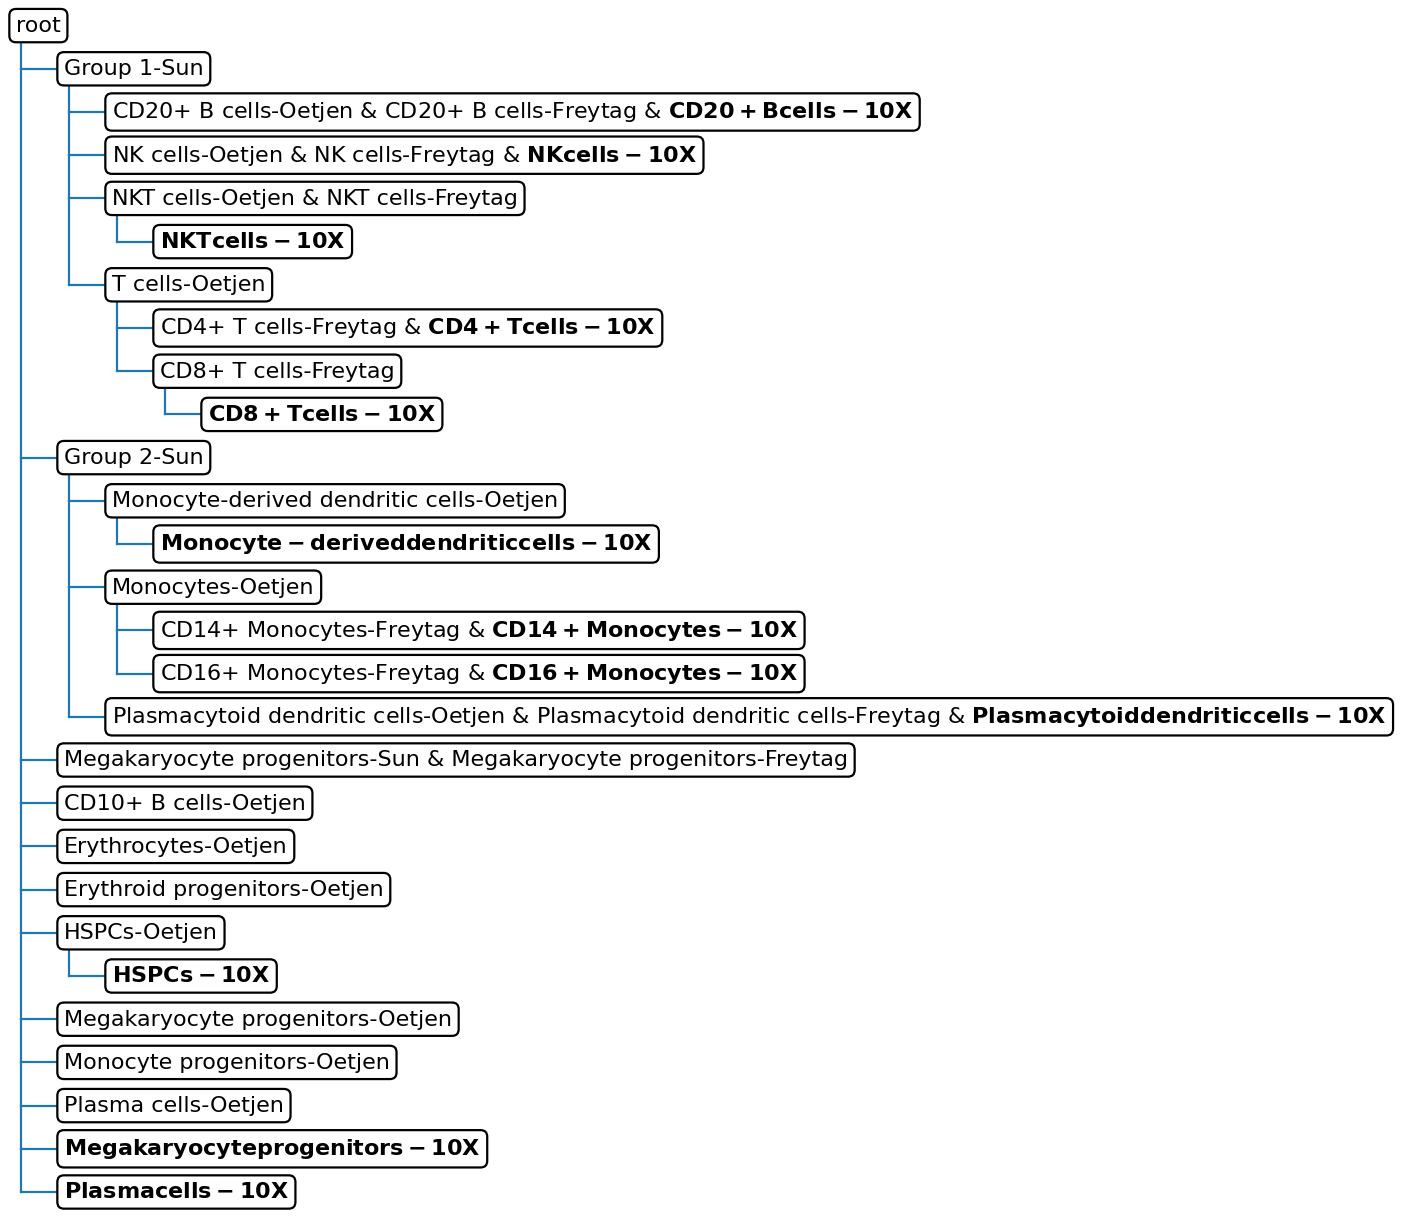

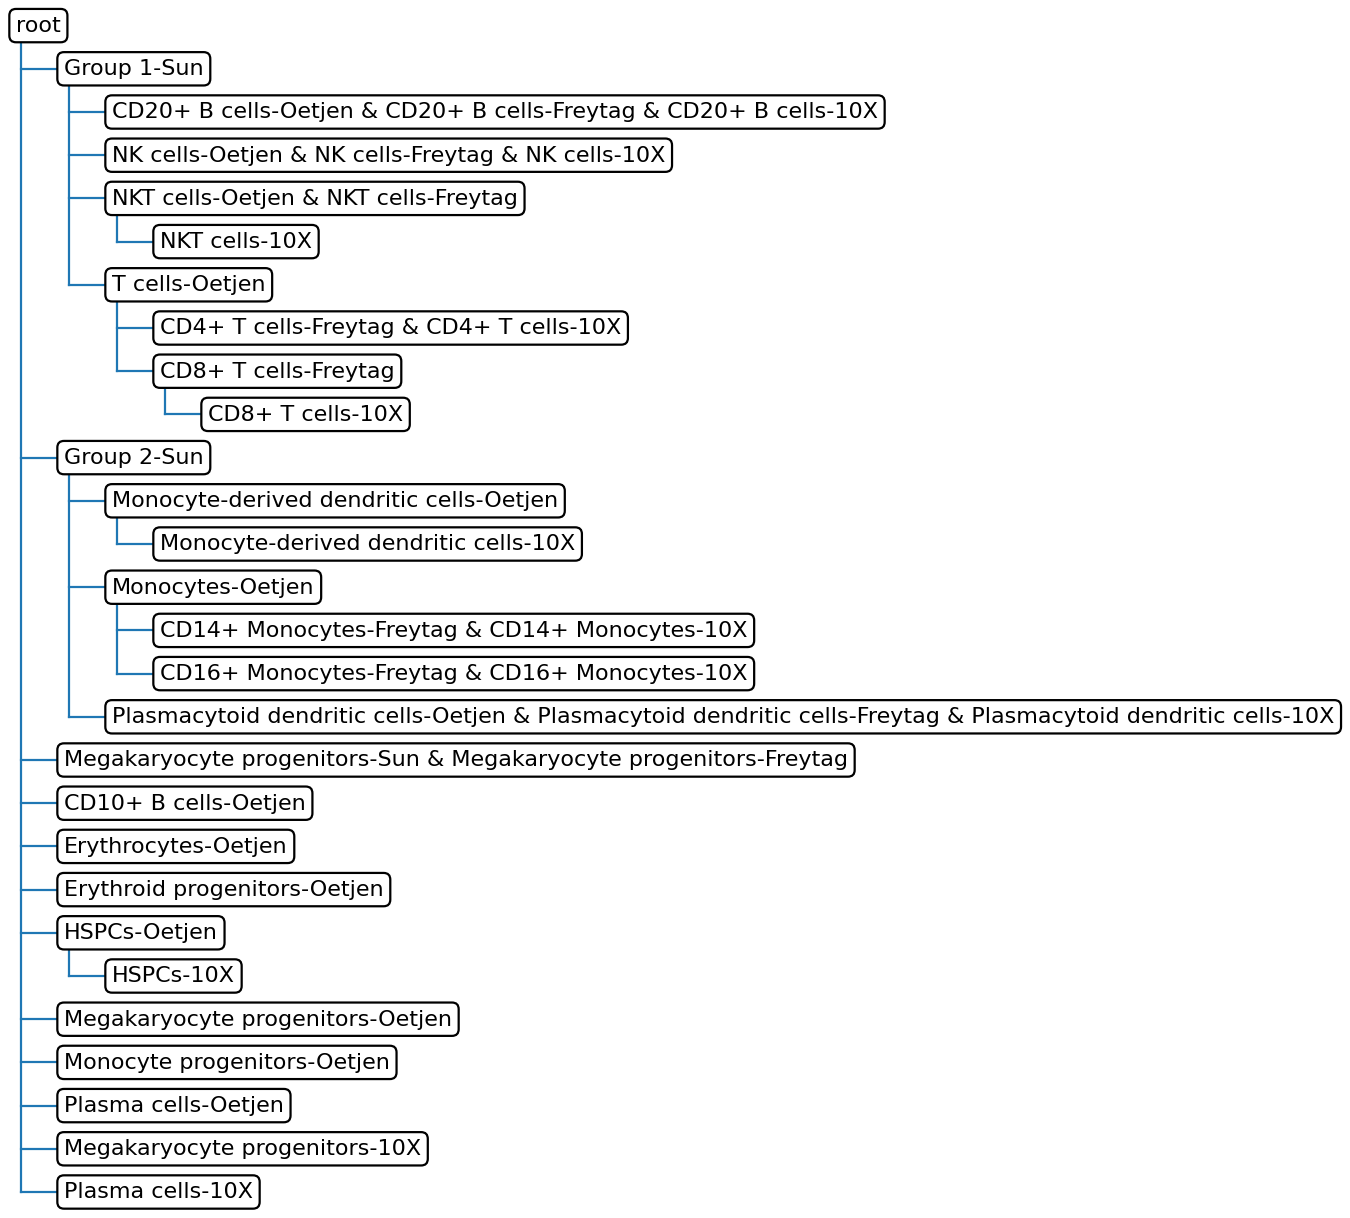

2
Use reconstruction error?:True
FN: 0.5
Starting tree:


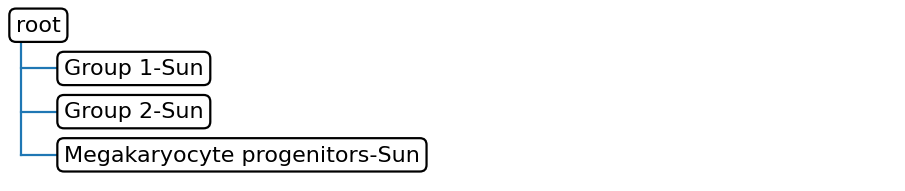


Adding dataset Oetjen to the tree

Updated tree:


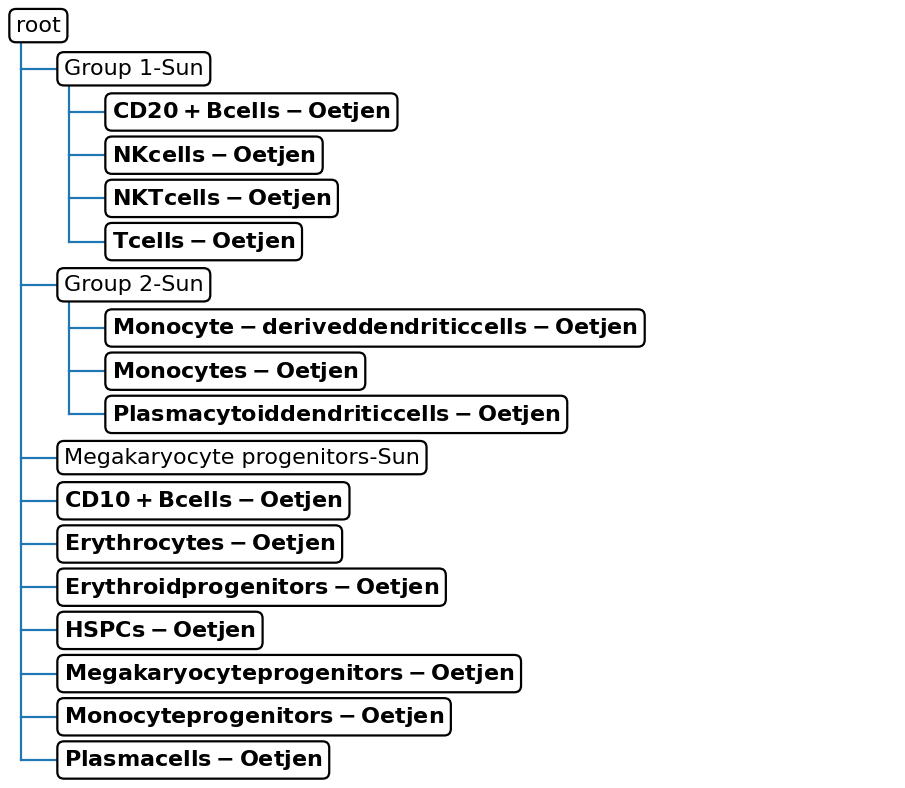


Adding dataset Freytag to the tree

Updated tree:


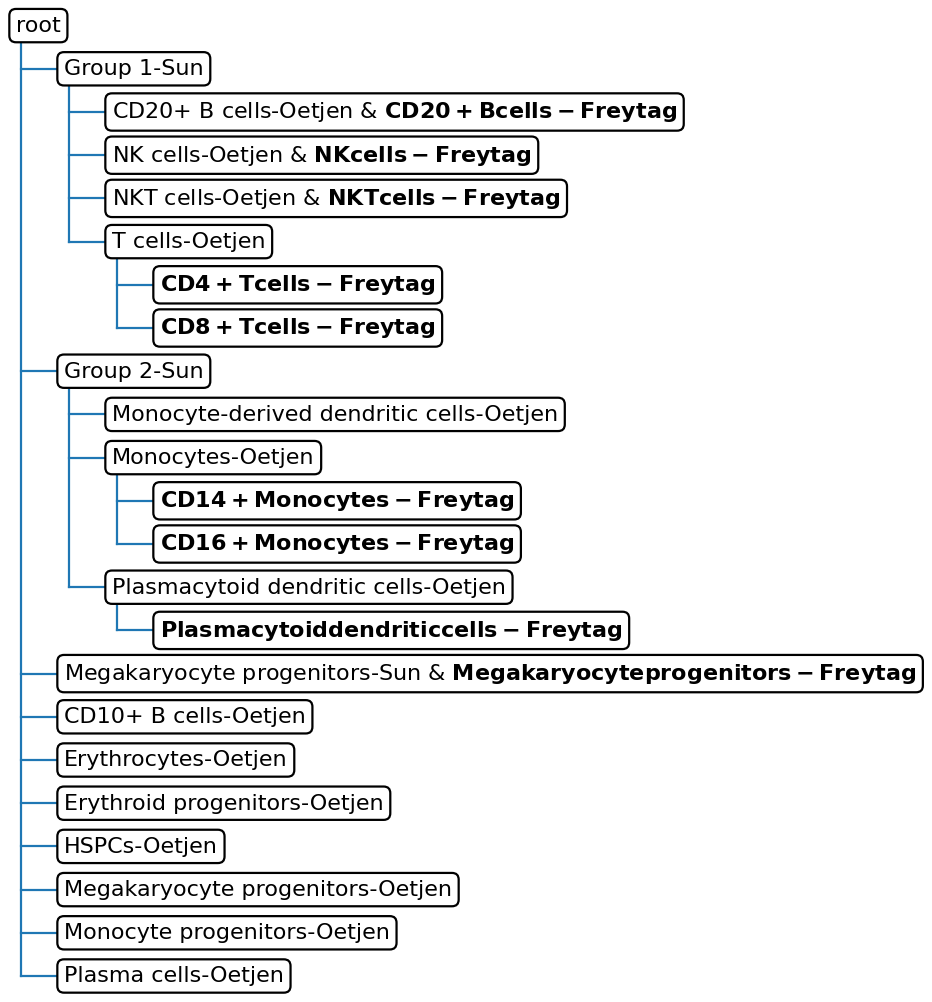


Adding dataset 10X to the tree

Updated tree:


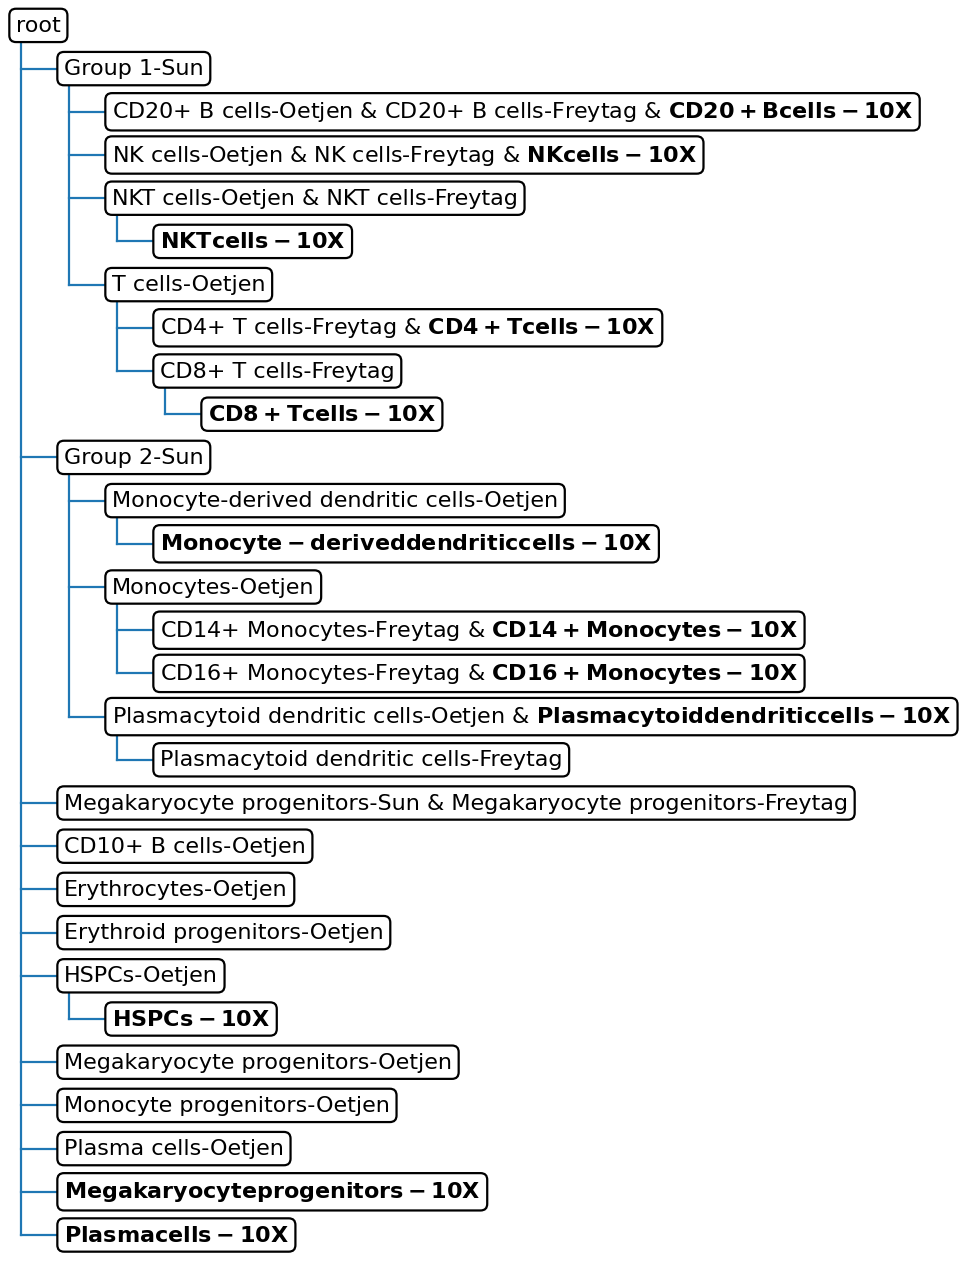

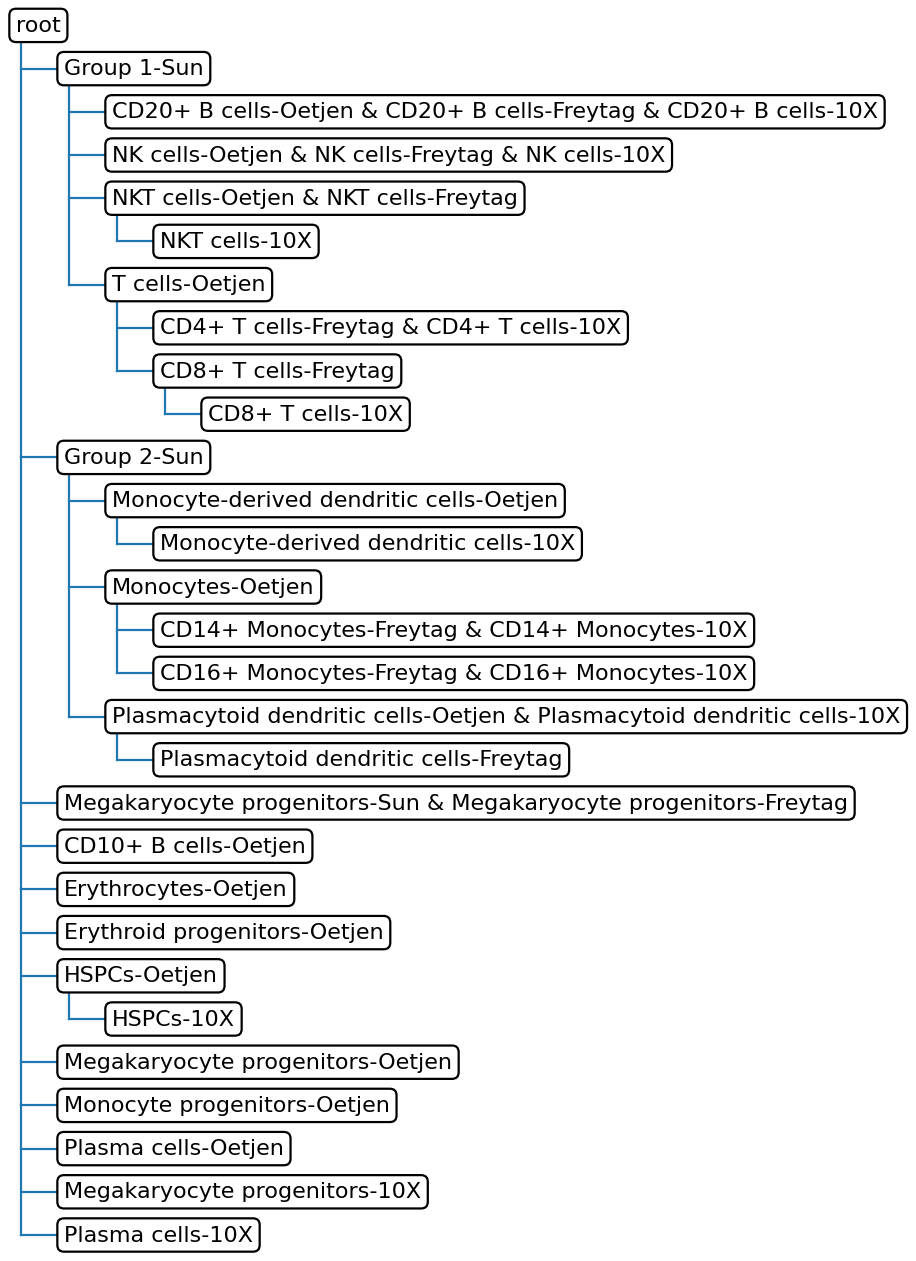

3
Use reconstruction error?:True
FN: 1
Starting tree:


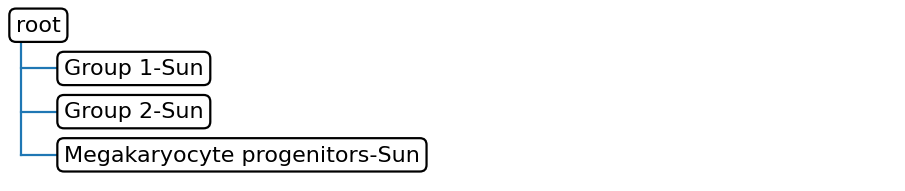


Adding dataset Oetjen to the tree

Updated tree:


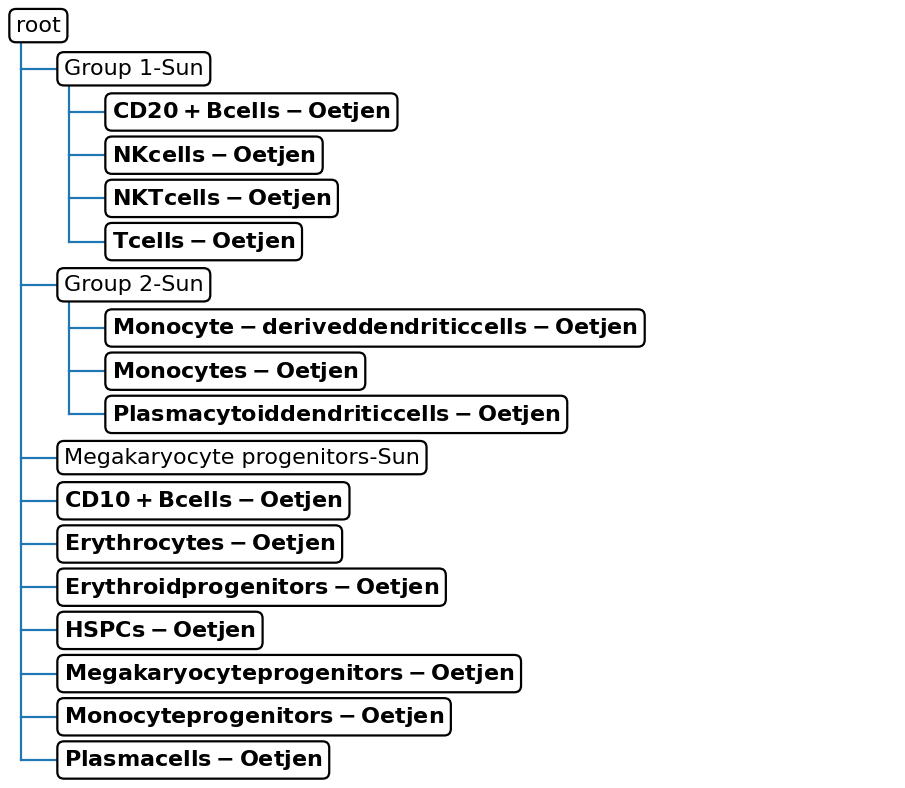


Adding dataset Freytag to the tree

Updated tree:


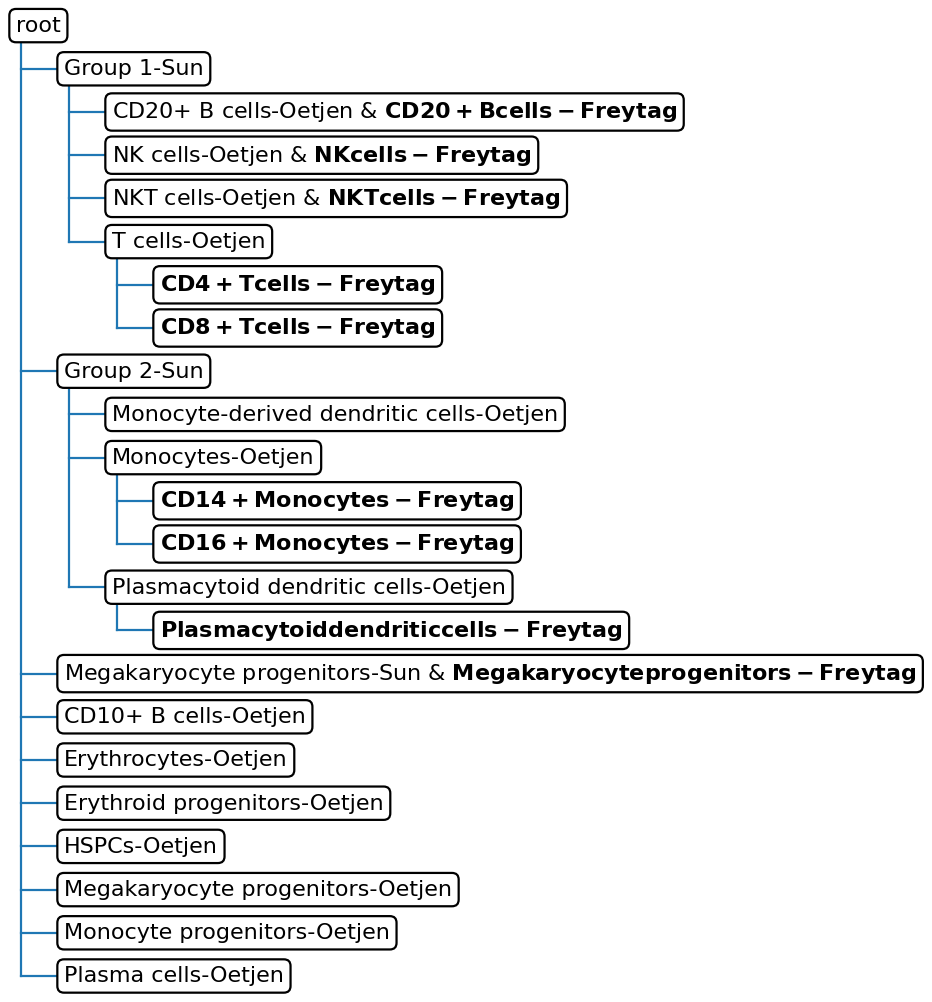


Adding dataset 10X to the tree

Updated tree:


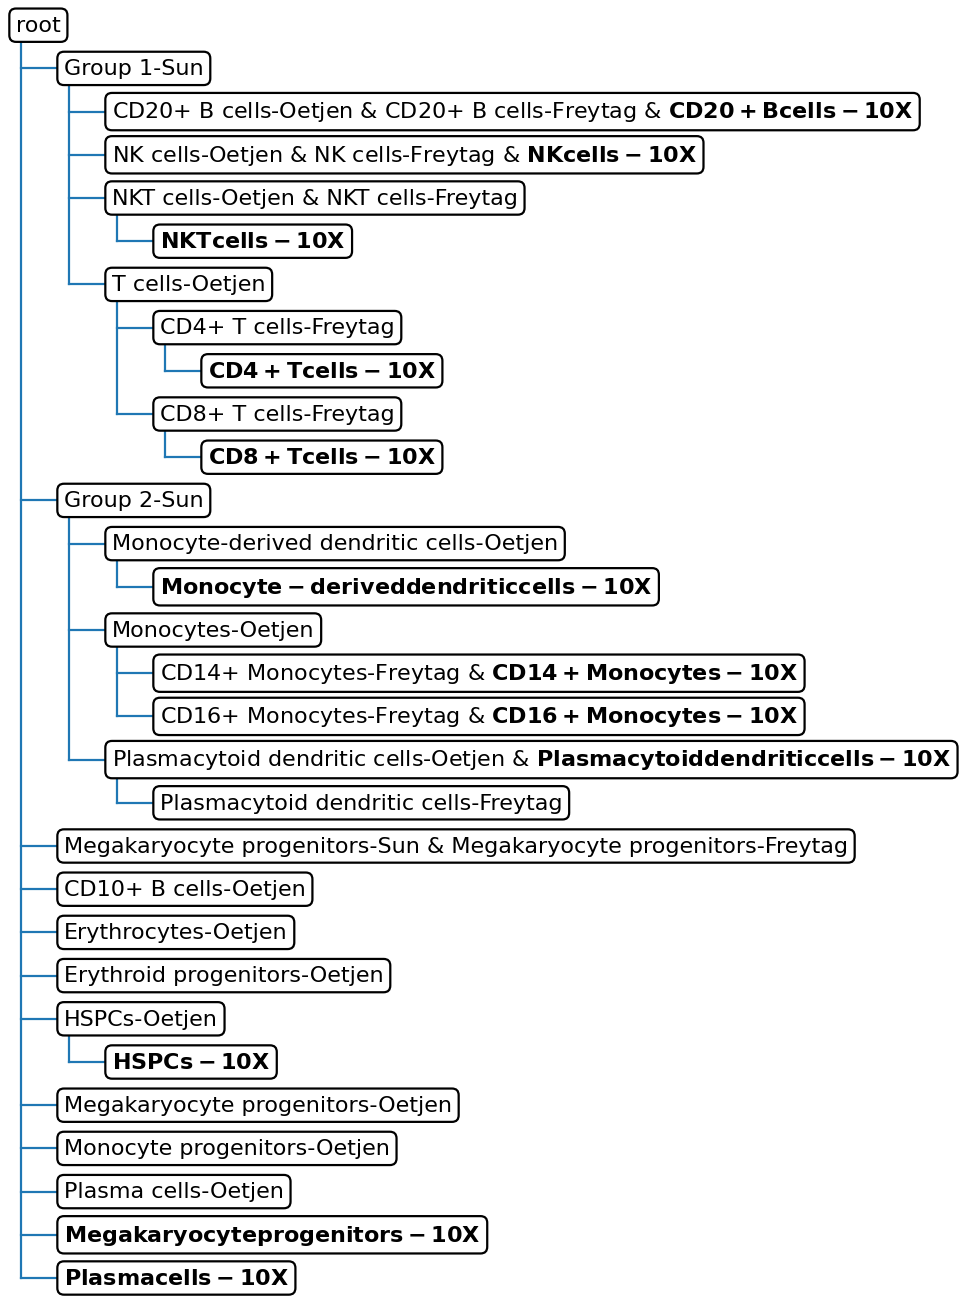

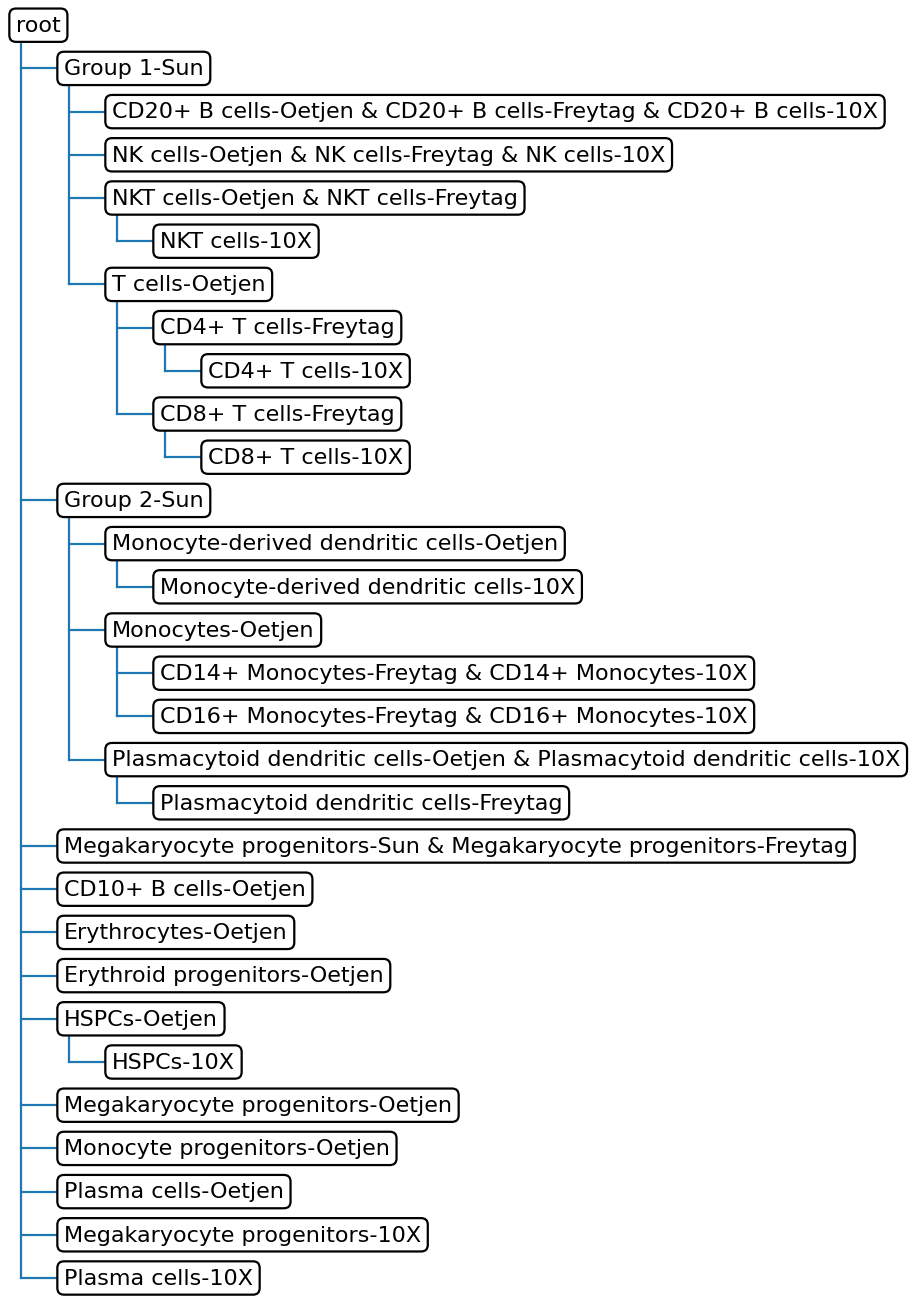

In [10]:
FN = [0.25, 0.5, 1]
i = 1

for fn in FN:
    if fn == 0:
        useRE = False
    else:
        useRE = True

    print(i)
    print('Use reconstruction error?:' + str(useRE))
    print('FN: ' + str(fn))


    tree, mp = sca.classifiers.scHPL.learn_tree(data = full_latent, 
                    batch_key = 'study',
                    batch_order = ['Sun', 'Oetjen', 'Freytag', '10X'],
                    cell_type_key='celltype_batch',
                    classifier = 'knn', dynamic_neighbors=True,
                    dimred = False, print_conf= False,
                    useRE = useRE, FN = fn)
    sca.classifiers.scHPL.utils.print_tree(tree)
    i += 1


1
Distance kNN: 95
Starting tree:


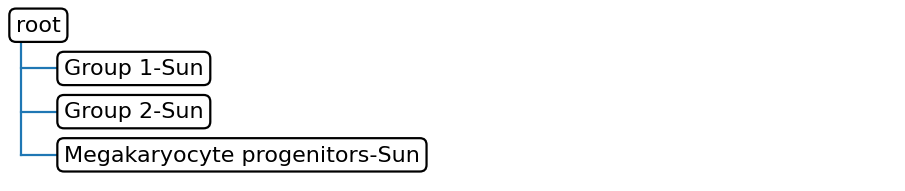


Adding dataset Oetjen to the tree

Updated tree:


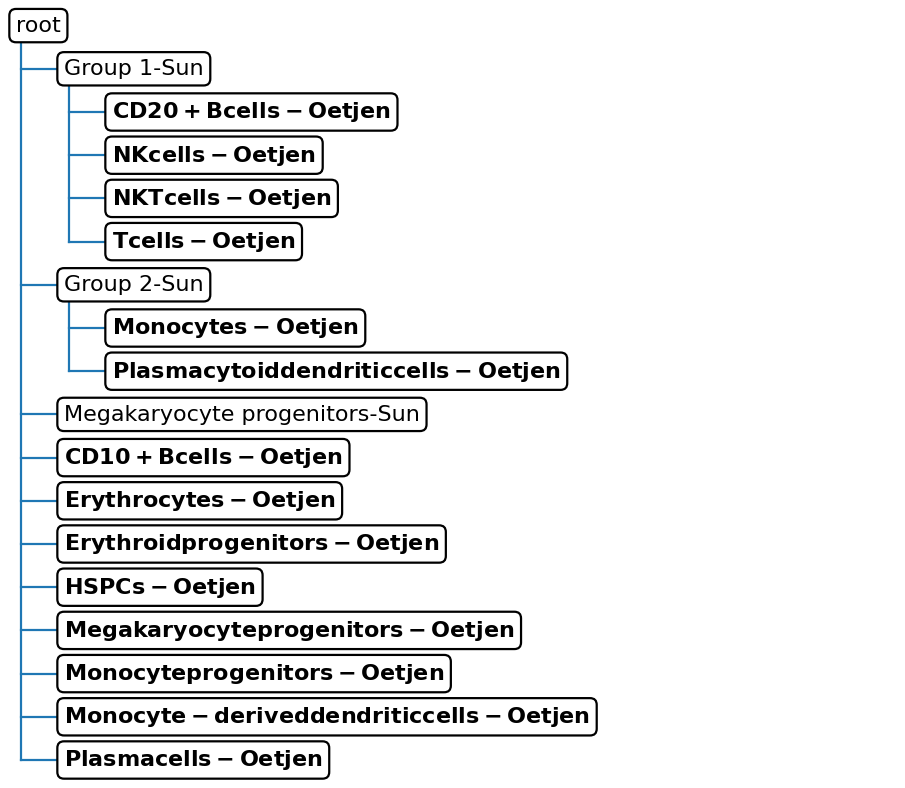


Adding dataset Freytag to the tree

Updated tree:


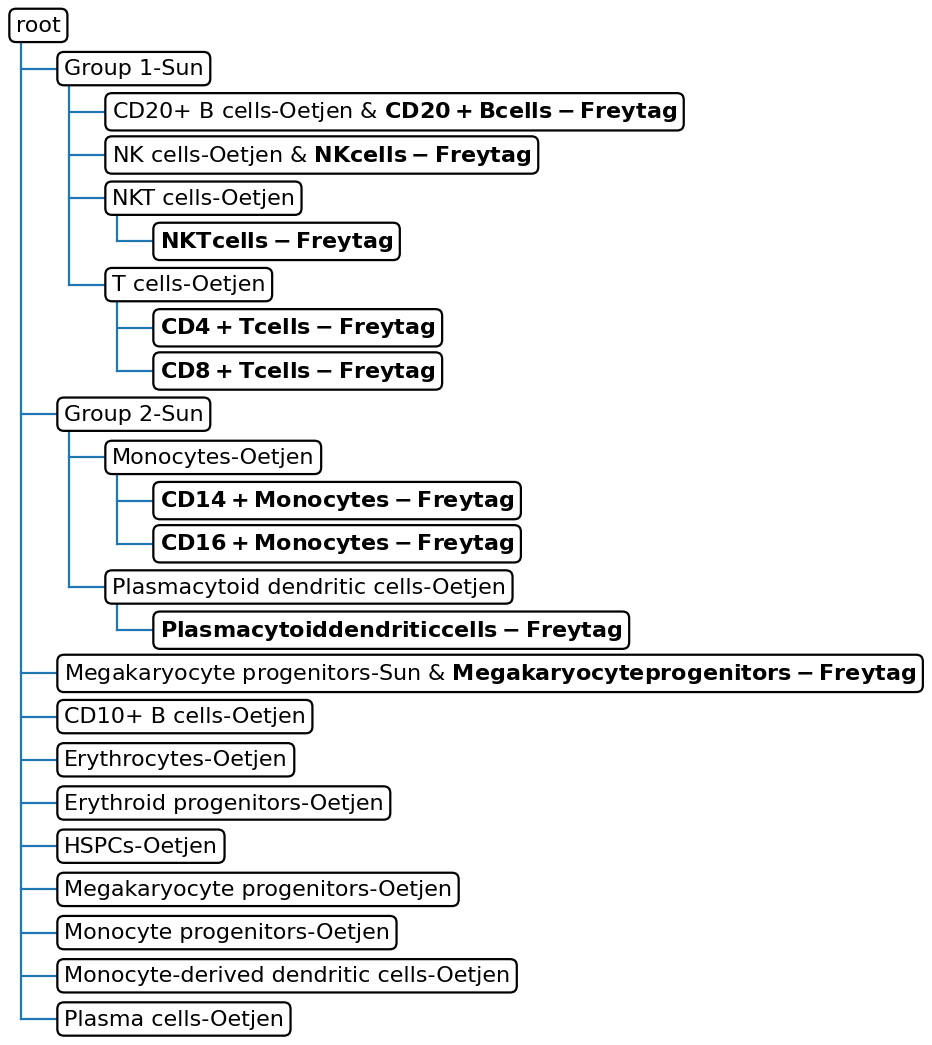


Adding dataset 10X to the tree
These populations are missing from the tree: 
['NKT cells-10X']

Updated tree:


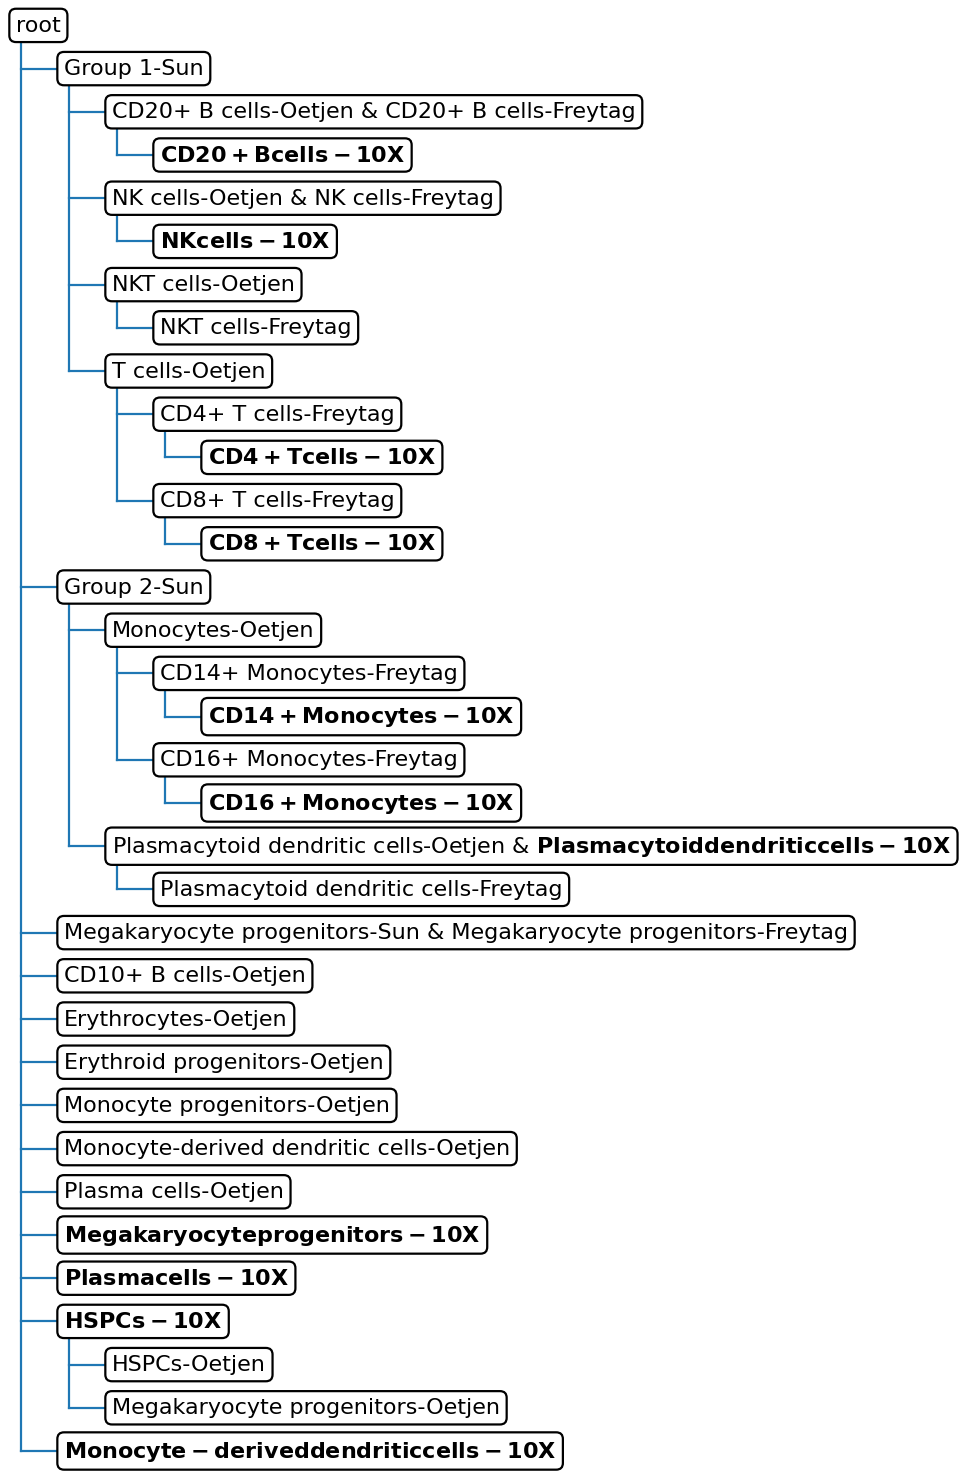

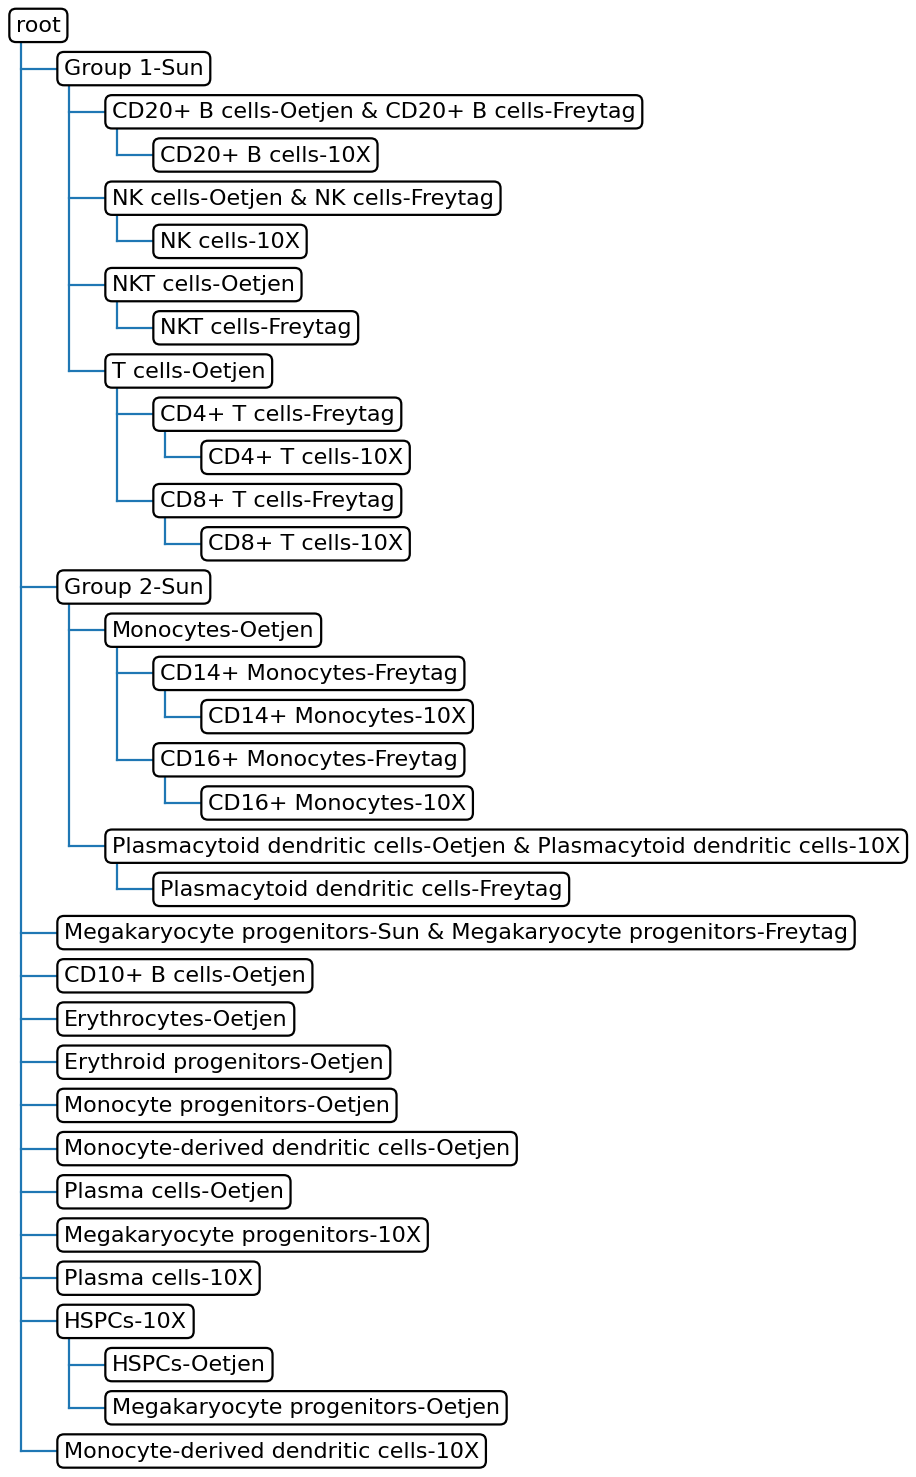

2
Distance kNN: 99
Starting tree:


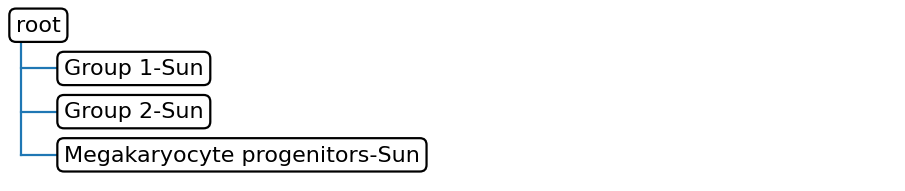


Adding dataset Oetjen to the tree

Updated tree:


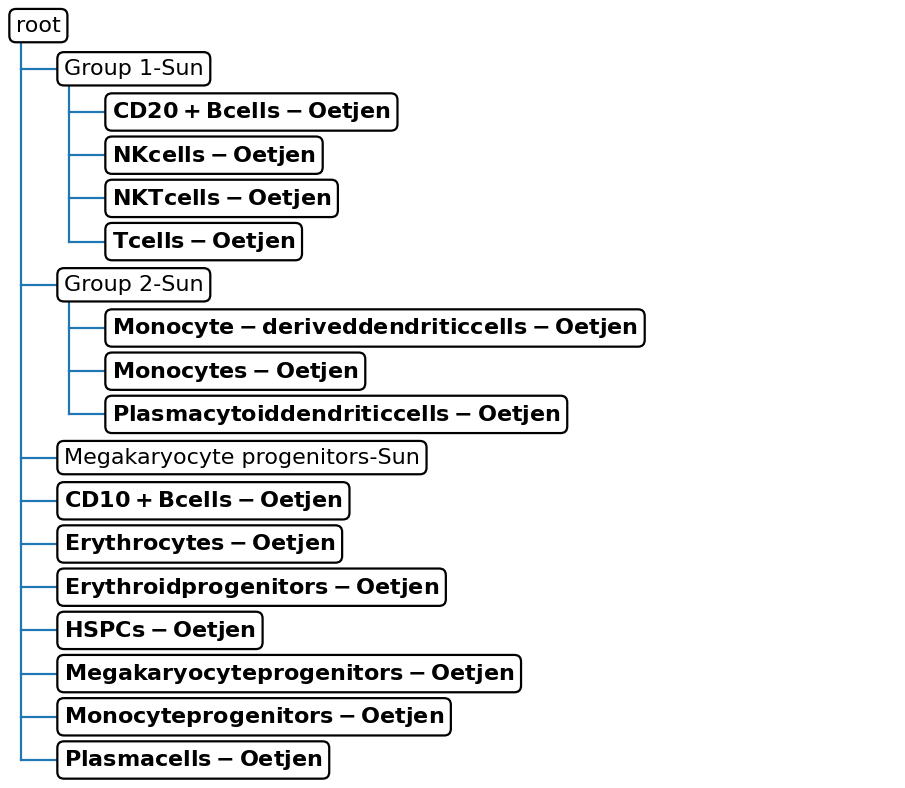


Adding dataset Freytag to the tree

Updated tree:


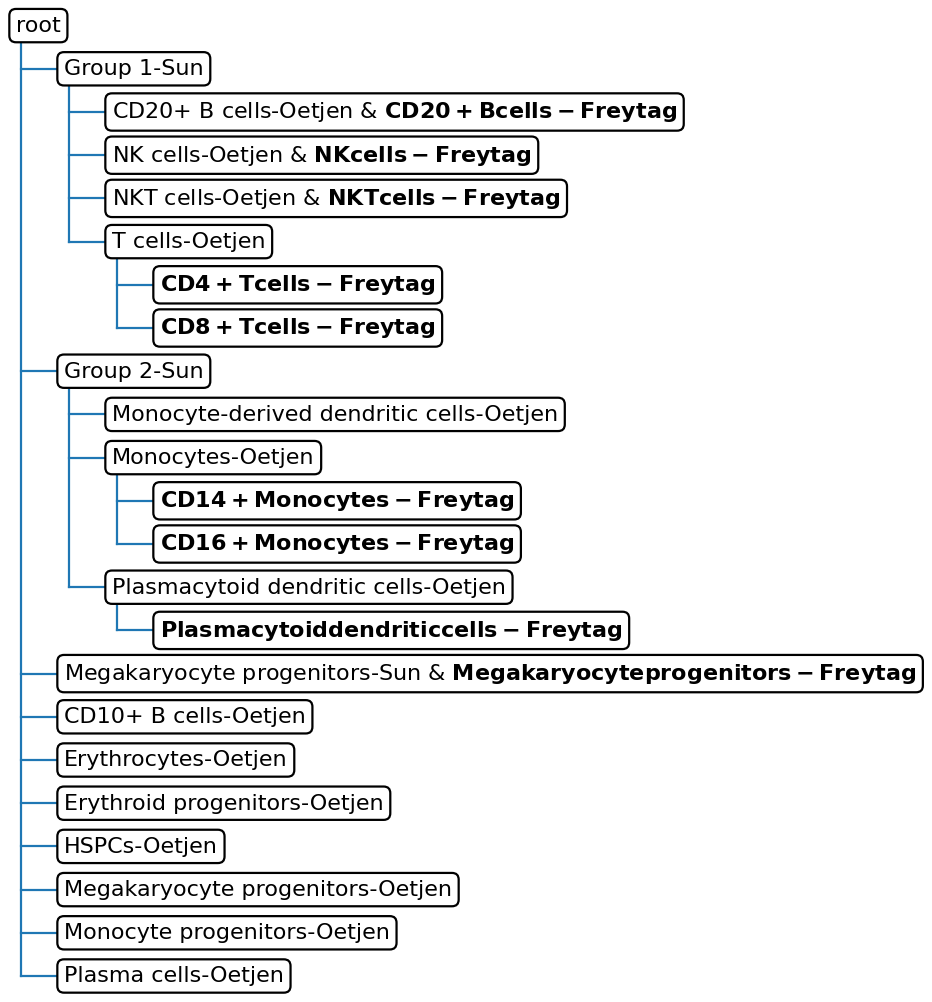


Adding dataset 10X to the tree

Updated tree:


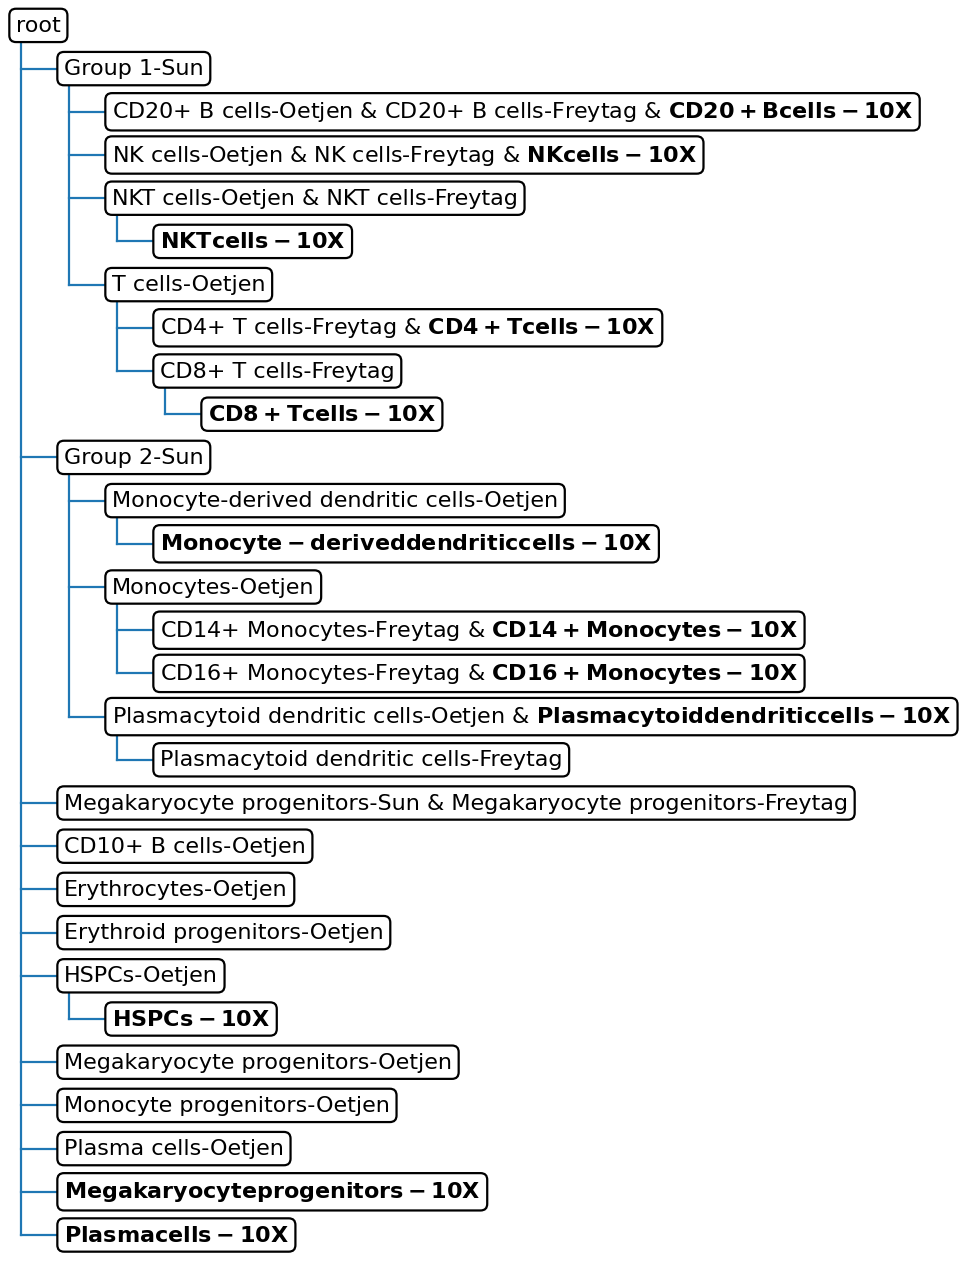

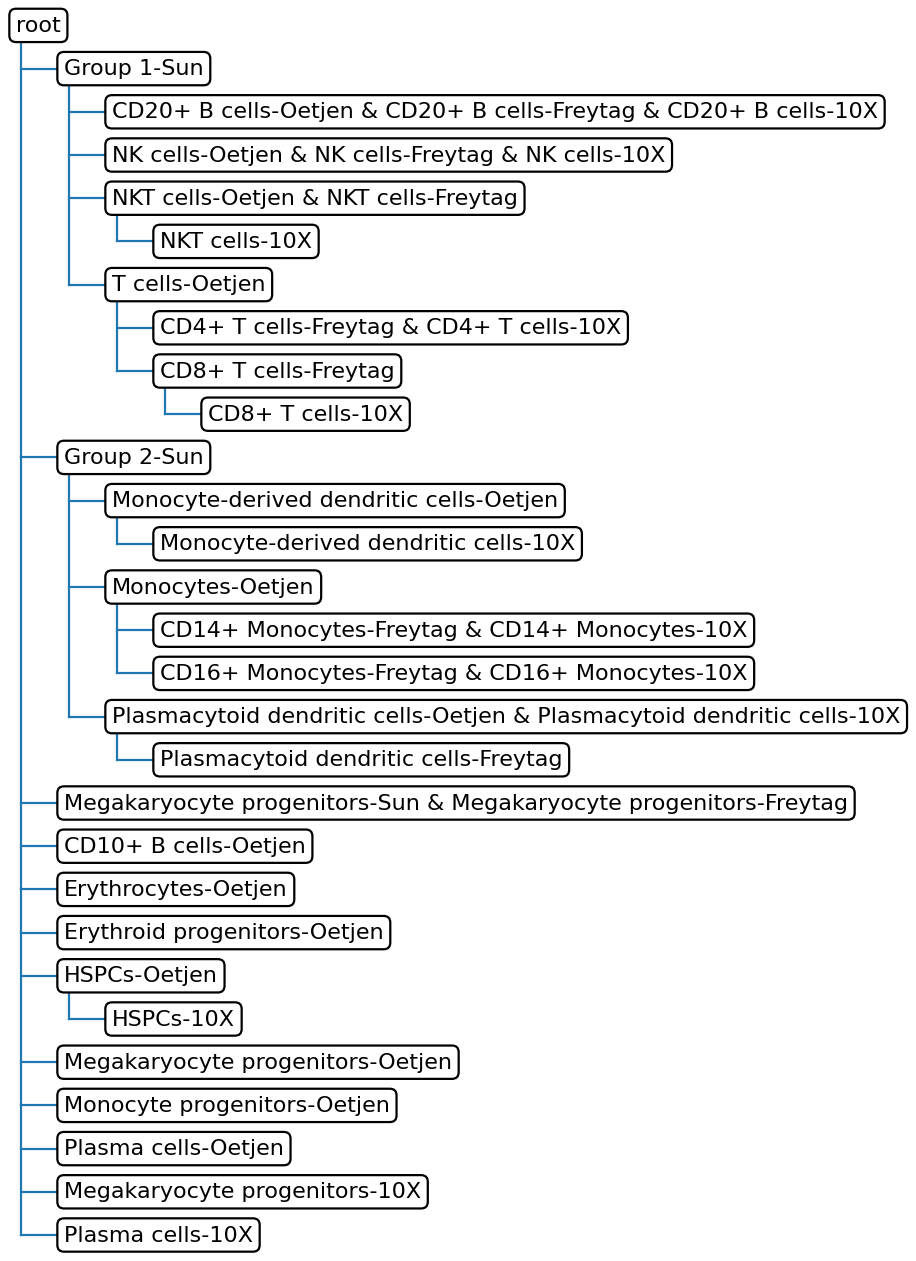

3
Distance kNN: 99.5
Starting tree:


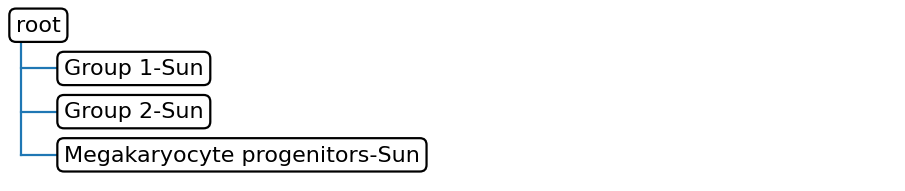


Adding dataset Oetjen to the tree

Updated tree:


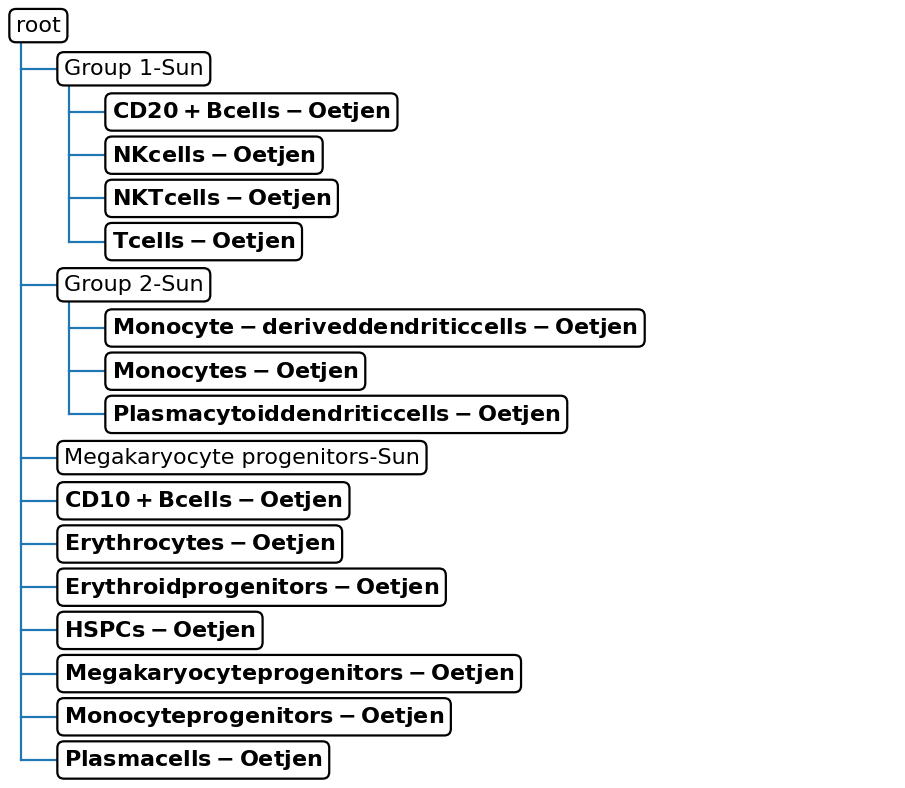


Adding dataset Freytag to the tree

Updated tree:


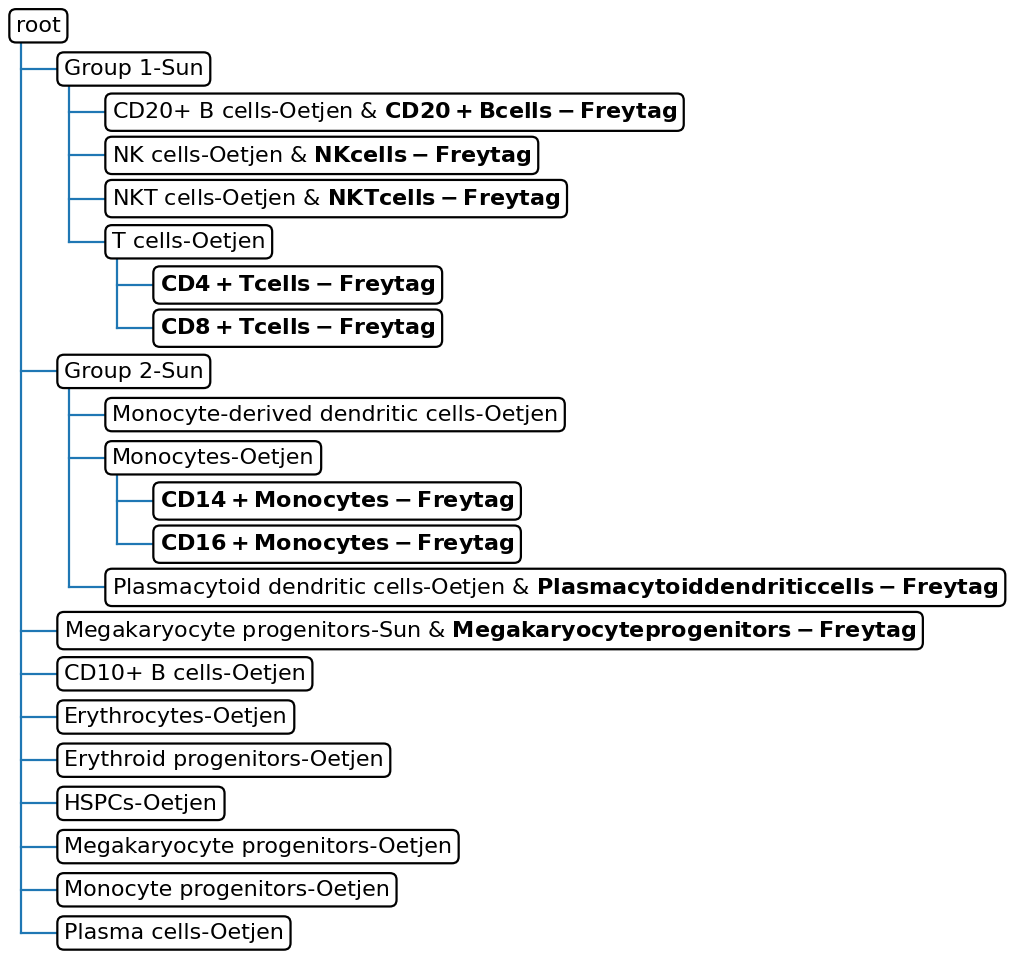


Adding dataset 10X to the tree

Updated tree:


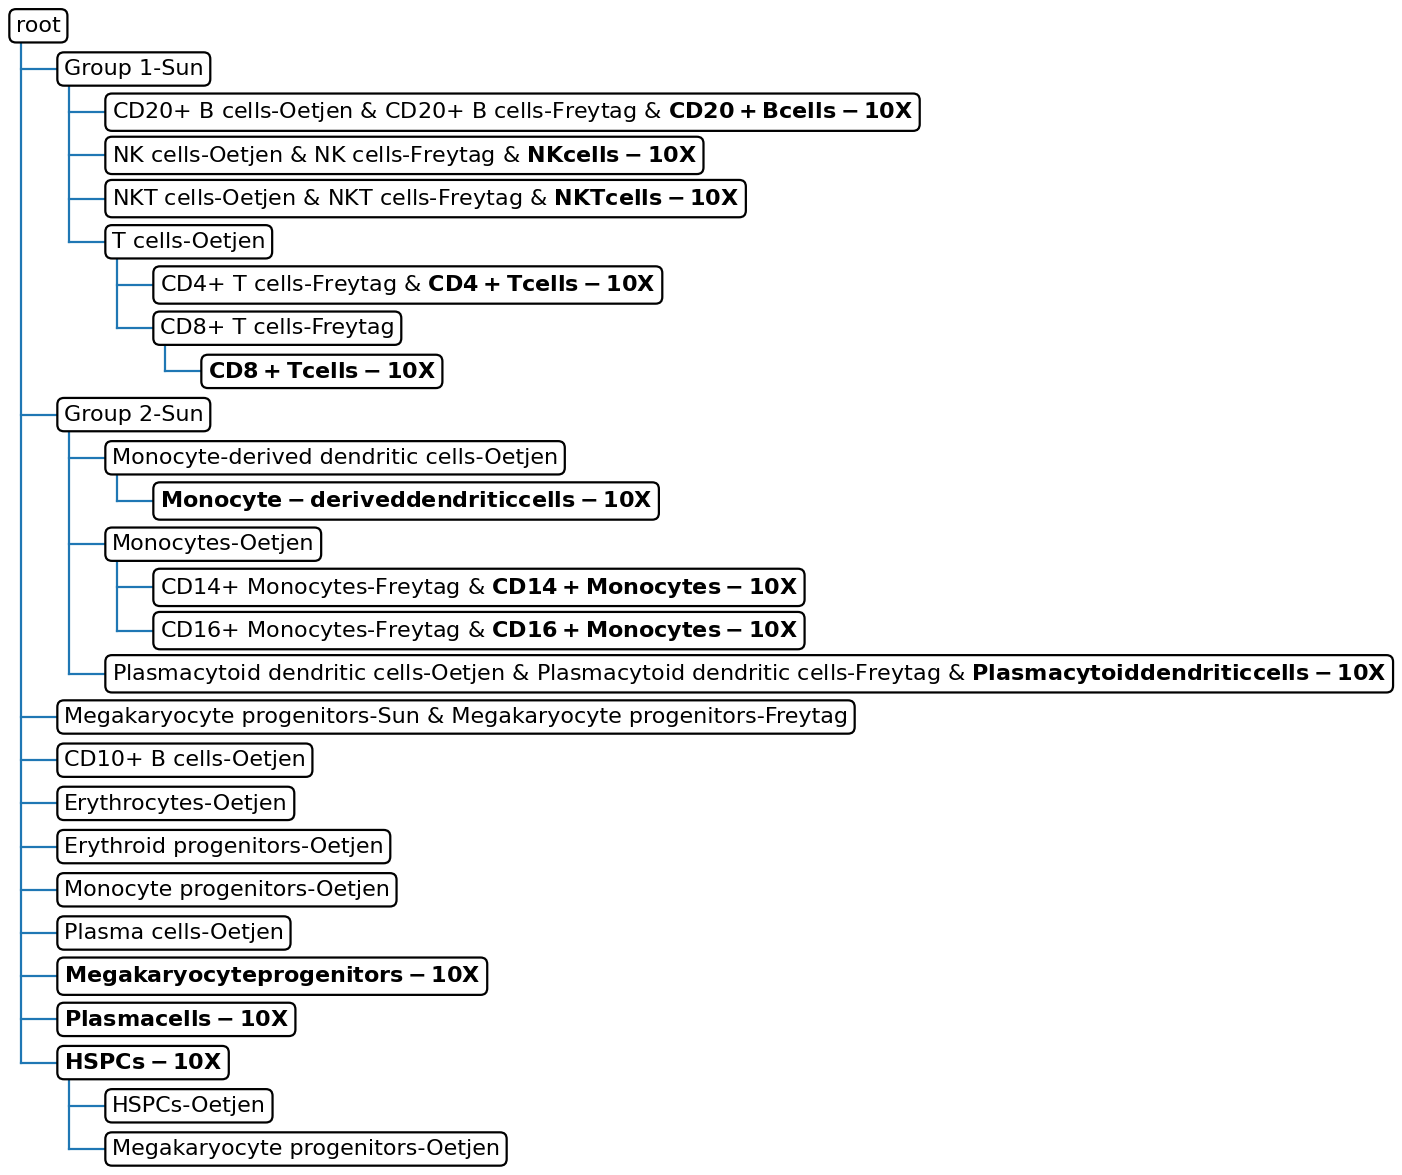

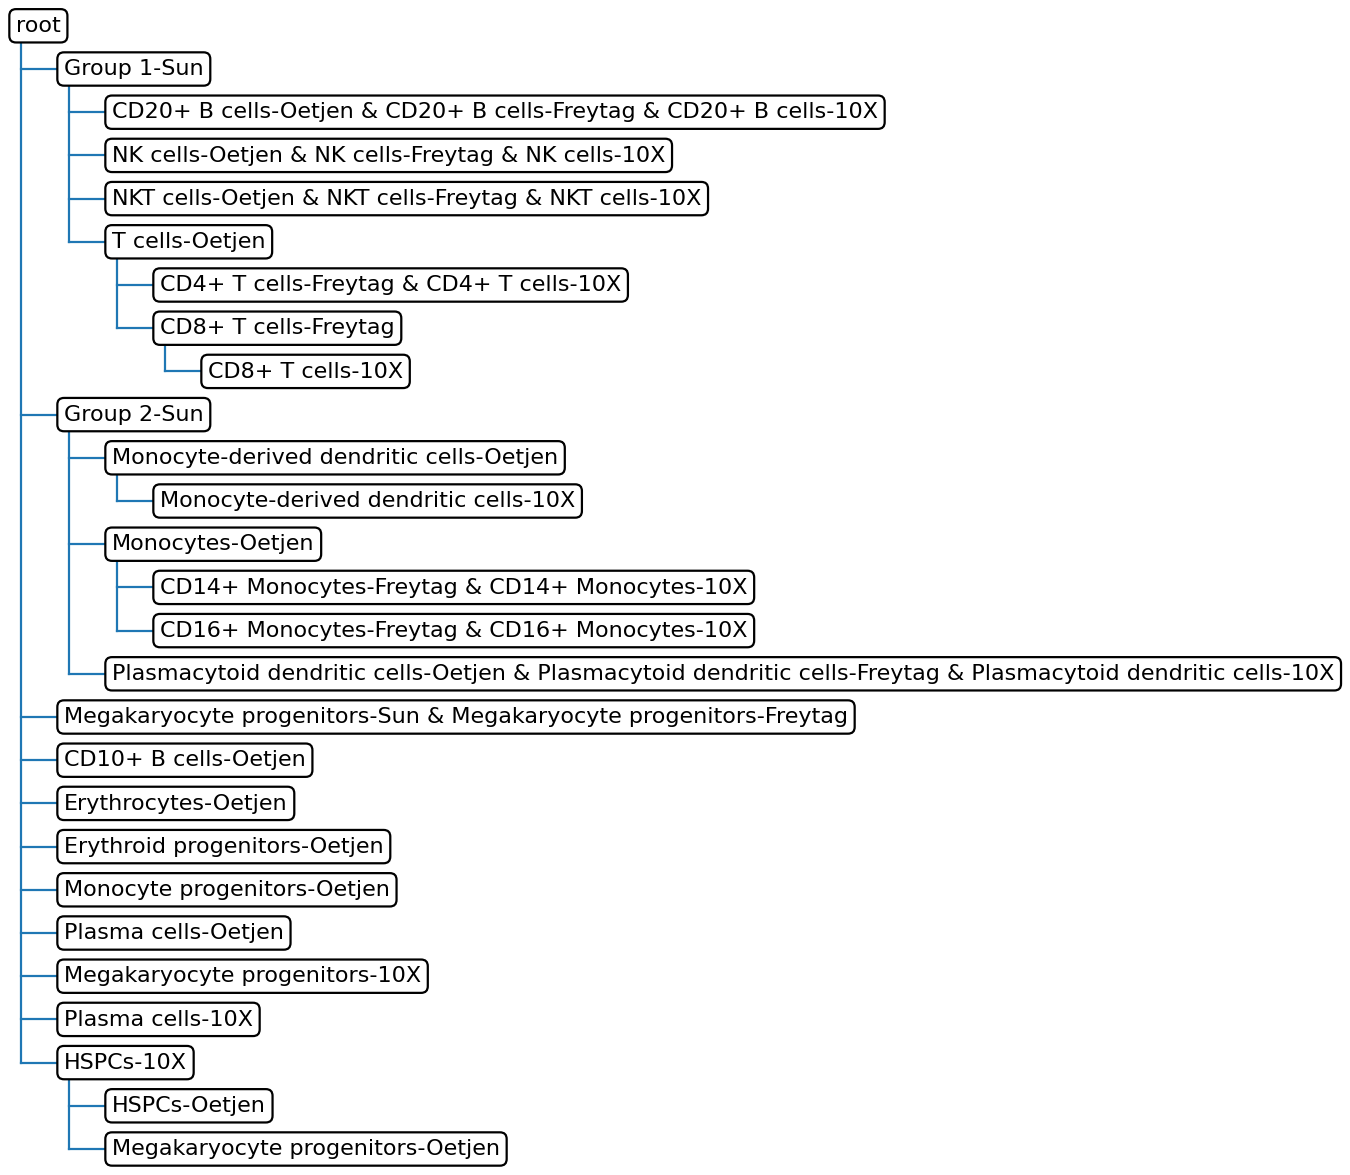

In [11]:
distkNN = [95, 99, 99.5]
i = 1

for dist in distkNN:
    print(i)
    print('Distance kNN: ' + str(dist))


    tree, mp = sca.classifiers.scHPL.learn_tree(data = full_latent, 
                    batch_key = 'study',
                    batch_order = ['Sun', 'Oetjen', 'Freytag', '10X'],
                    cell_type_key='celltype_batch',
                    classifier = 'knn', dynamic_neighbors=True,
                    dimred = False, print_conf= False, distkNN = dist)
    sca.classifiers.scHPL.utils.print_tree(tree)
    i += 1


Starting tree:


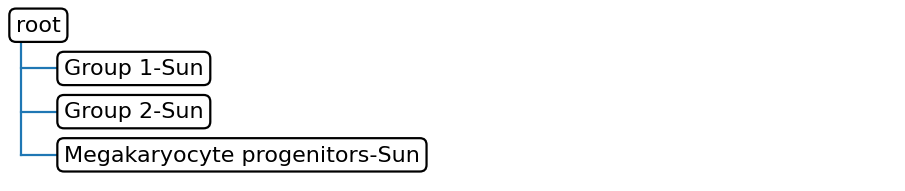


Adding dataset Oetjen to the tree

Updated tree:


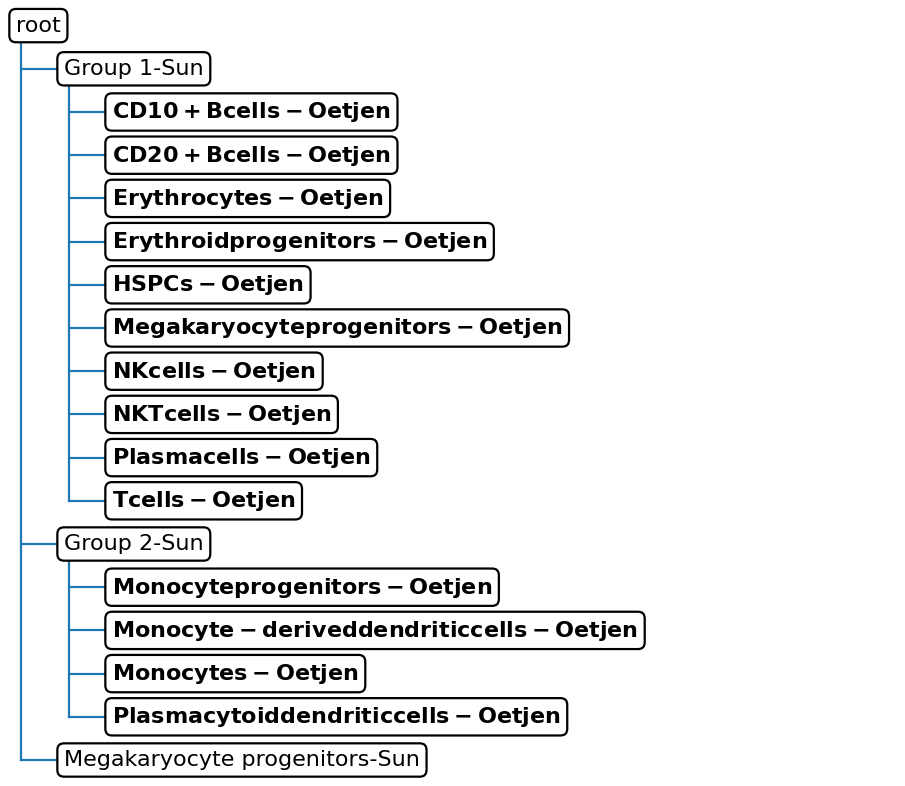


Adding dataset Freytag to the tree
These populations are missing from the tree: 
['CD14+ Monocytes-Freytag' 'CD16+ Monocytes-Freytag'
 'CD4+ T cells-Freytag' 'CD8+ T cells-Freytag']

Updated tree:


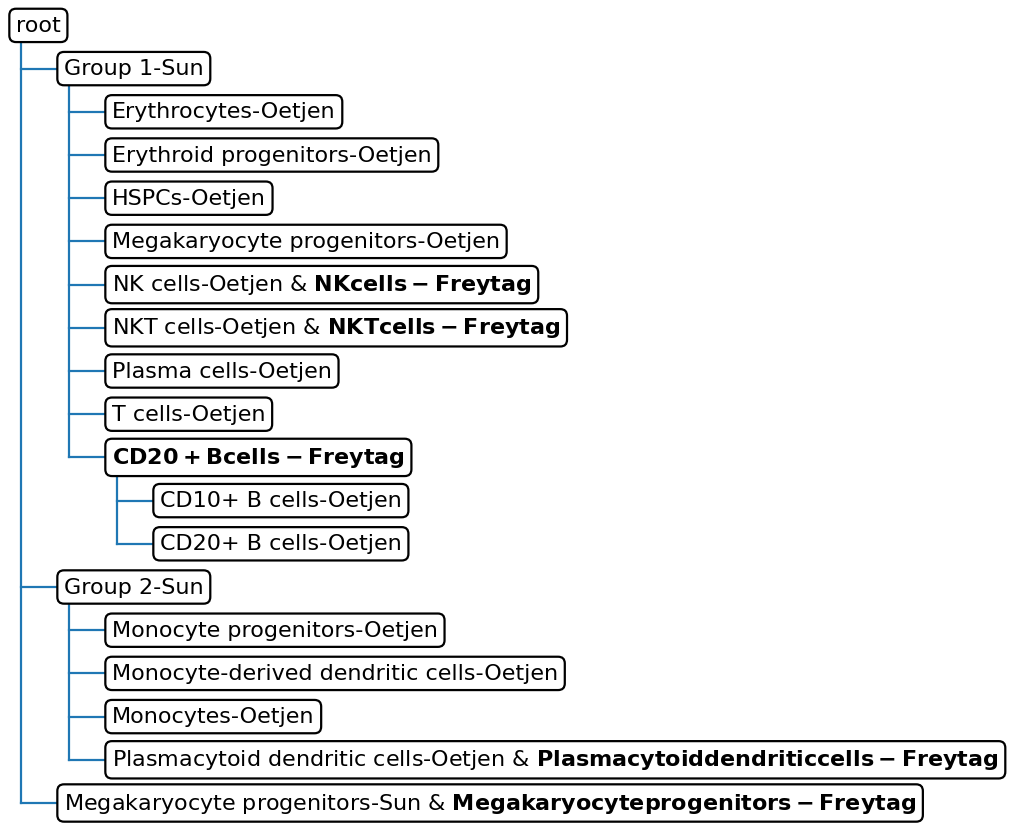


Adding dataset 10X to the tree
These populations are missing from the tree: 
['Plasma cells-10X']

Updated tree:


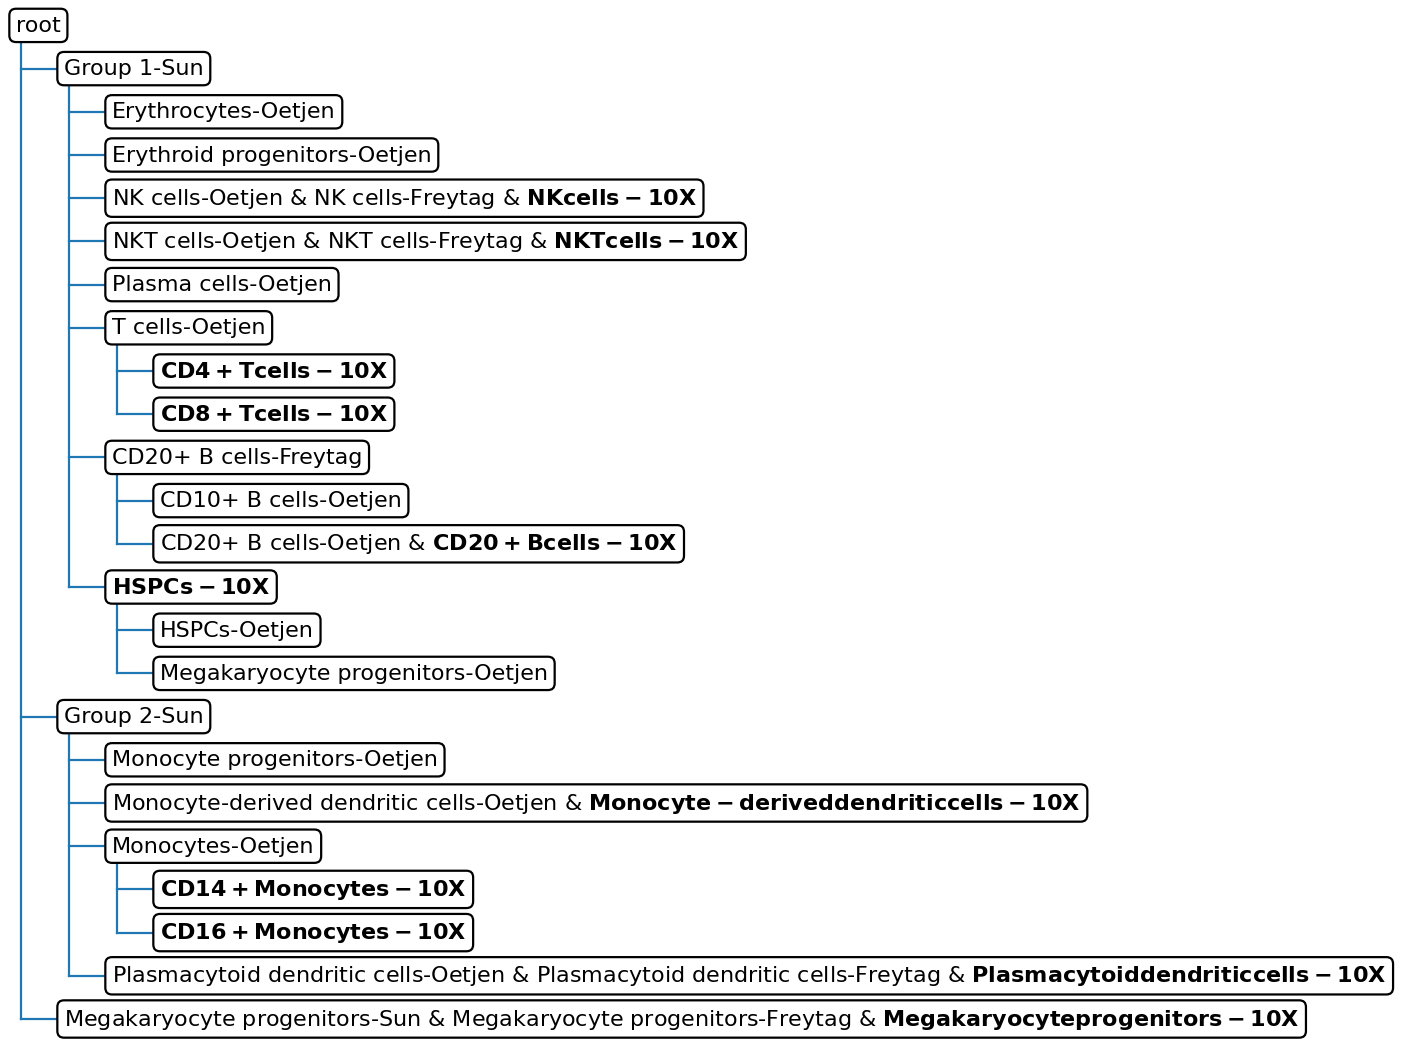

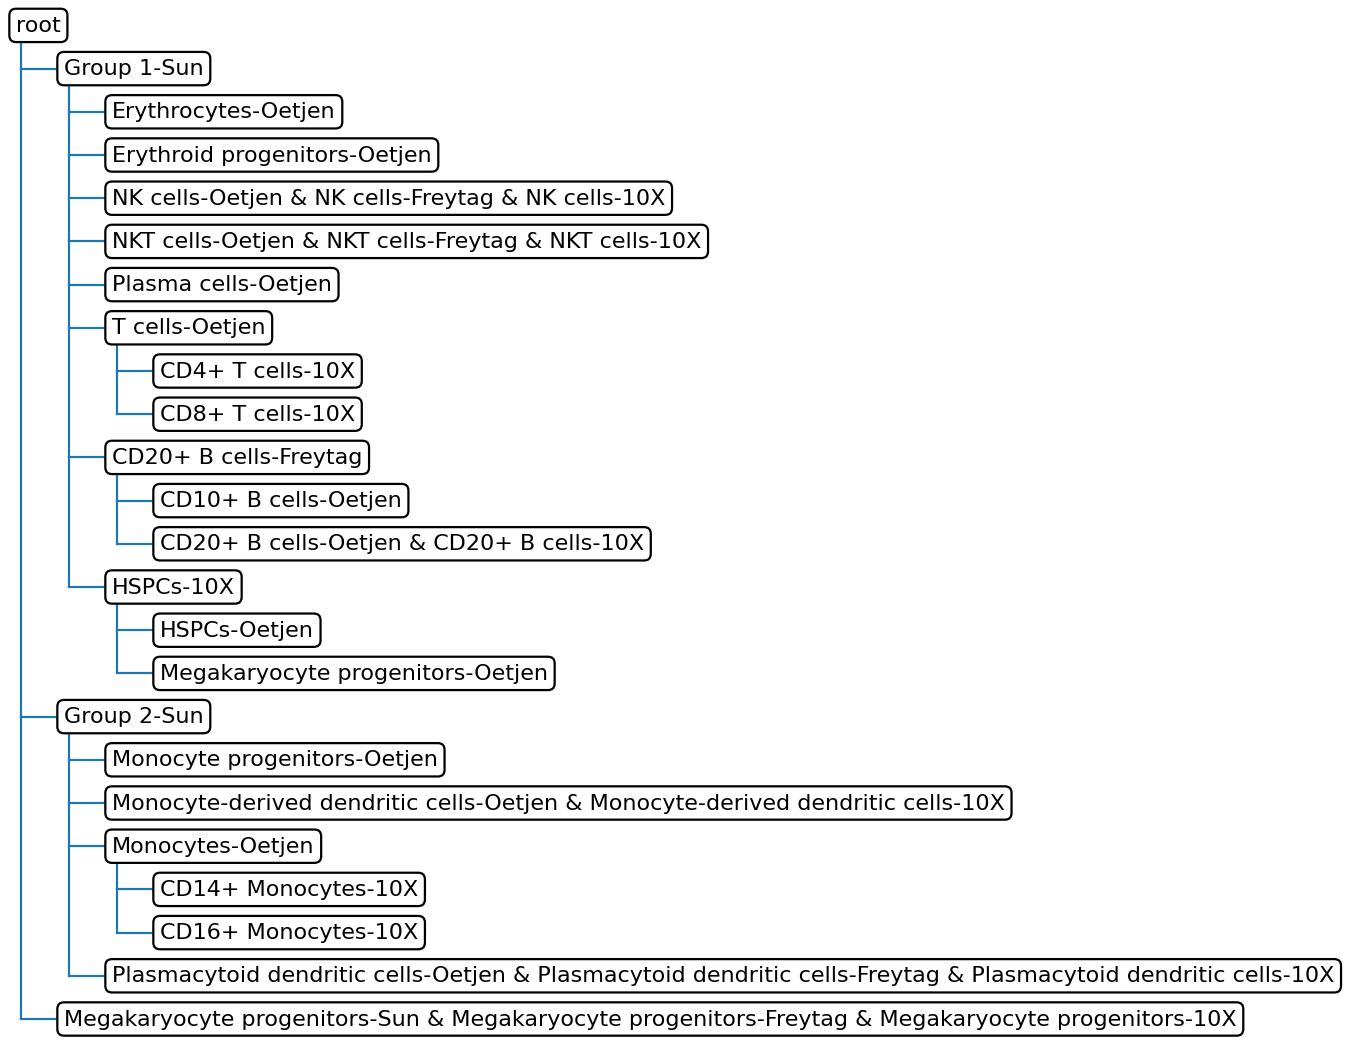

In [12]:
# No rejection option

tree, mp = sca.classifiers.scHPL.learn_tree(data = full_latent, 
                batch_key = 'study',
                batch_order = ['Sun', 'Oetjen', 'Freytag', '10X'],
                cell_type_key='celltype_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False,
                useRE = False, FN = fn,
                distkNN = 100, rej_threshold=0)
sca.classifiers.scHPL.utils.print_tree(tree)
